# Matching

In [1]:
import numpy as np
import uproot
import vector
import awkward as ak
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
import itertools

directory = "/Users/archiebrooks/Documents/Uni/mphys project/"
#directory = "c:/Users/matis/OneDrive/Documents/Y4/Project/"

hep.style.use('ATLAS')

## Functions and Maps

In [2]:
def histogram(data, bins, data_label, axes, density=False, ratio=False, ratio_axes=None, set_range = None, weight_array=None, x_units='GeV', print_peak=False):
    if len(data[0]) != 1:
        if set_range is not None:
            global_min, global_max = set_range
        else:
            global_min = min([np.min(d) for d in data])
            global_max = max([np.max(d) for d in data])

        bin_edges = np.linspace(global_min, global_max, bins+1)
        counts = []
        errors = []
        bin_width = bin_edges[1]-bin_edges[0]
        for i in range(len(data)):
            if type(data[i])!= 'numpy.ndarray':
                data[i] = np.array(ak.to_numpy(data[i]))
            hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
            hist.fill(data[i], weight=weight_array[i]) if weight_array is not None else hist.fill(data[i])
            norm_factor = np.sum(hist.counts() * np.diff(hist.axes[0].edges))
            if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances())/norm_factor,label=data_label[i], histtype='step')
            else: hep.histplot(hist.counts(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()),label=data_label[i], histtype='step')
            counts.append(hist.counts()/norm_factor) if density else counts.append(hist.counts())
            errors.append(np.sqrt(hist.variances())/norm_factor) if density else errors.append(np.sqrt(hist.variances()))       
            if print_peak:
                peak_bin_index = np.argmax(hist.counts())
                peak_bin_center = (hist.axes[0].edges[peak_bin_index] + hist.axes[0].edges[peak_bin_index + 1]) / 2
                print(f"Peak bin center for {data_label[i]}: {peak_bin_center:.2f} {x_units}")
    else:
        hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
        hist.fill(data)
        hep.histplot(hist.view(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()), label=data_label, histtype='step')
        if print_peak:
                peak_bin_index = np.argmax(hist.counts())
                peak_bin_center = (hist.axes[0].edges[peak_bin_index] + hist.axes[0].edges[peak_bin_index + 1]) / 2
                print(f"Peak bin center for {data_label}: {peak_bin_center:.2f} {x_units}")

    bin_width = hist.axes[0].edges[1]-hist.axes[0].edges[0]
    axes.set_ylabel(f'Events /{bin_width:.2g} {x_units}')
    axes.legend()

    if ratio:
        reference_counts = counts[0]
        for i in range(1, len(counts)):
            ratio_values = np.divide(counts[i], reference_counts, out=np.zeros_like(counts[i]), where=reference_counts != 0)
            ratio_errors = np.sqrt(np.divide(errors[i],counts[i], out=np.zeros_like(counts[i]), where=counts[i]!=0)**2 + (np.divide(errors[0],counts[0], out=np.zeros_like(counts[0]), where=counts[0]!=0)**2))
            hep.histplot(ratio_values, bin_edges, ax=ratio_axes, yerr=ratio_errors, label=f'{data_label[i]}/{data_label[0]}')
        ratio_axes.set_ylabel("Ratio")
        ratio_axes.set_xlabel(axes.get_xlabel())
        ratio_axes.axhline(1, color='black', linestyle='--')  # Reference line at ratio=1
        ratio_axes.legend()
        if ratio_axes.get_ylim()[1]>5:
            ratio_axes.set_ylim(0,5)

    hep.atlas.label(ax=axes)

def n_combinations(particles, n, dictionary, type):
    i = n
    while len(particles[ak.num(particles)>=i])!=0:
        particles_i = particles[ak.num(particles)==i]
        if len(particles_i)==0:
            i+=1
            continue
        indices = np.array(list(itertools.combinations(range(np.shape(particles_i)[1]), n)))
        dictionary[type+f'_{i}'] = particles_i[:, indices]
        i += 1
    return None




mass_lookup = {
    1: 2.16E-3,
    2: 4.7E-3,
    3: 1.273,
    4: 93.5E-3,
    5: 172.57,
    6: 4.183,
    11: 0.511E-3,
    12: 0,
    13: 105.66E-3,
    14: 0,
    15: 1.77693,
    16: 0,
    21: 0
}

def duplicate_cleaner(matched_pairs, truth=None):
    truth_ids = matched_pairs['truth']['id']
    deduped_id_pairs = ak.Array([list(dict.fromkeys(row)) for row in ak.to_list(truth_ids)])
    no_repeats = ak.num(deduped_id_pairs) == ak.num(truth_ids)
    one_repeat = ak.num(deduped_id_pairs) == ak.num(truth_ids) - 1

    duplicate_pairs = matched_pairs[one_repeat]
    clean_pairs = matched_pairs[no_repeats]
    if truth is not None:
        duplicate_truth = truth[one_repeat]
        return clean_pairs, duplicate_pairs, duplicate_truth
    
    return clean_pairs, duplicate_pairs

def duplicate_matcher(repeat, dupe_truth):
    fixable_repeats = repeat[ak.num(repeat)>2]

    repeat_truth, valid_particles, duplicate_particles = [], [], []

    for i in range(1,len(dupe_truth[0])+1):

        repeat_ids = fixable_repeats['truth']['id']
        repeat_i = fixable_repeats[ak.num(repeat_ids[repeat_ids==i], axis=1)==2]
        repeat_ids_i = repeat_ids[ak.num(repeat_ids[repeat_ids==i], axis=1)==2]
        repeat_truth.append(dupe_truth[ak.num(repeat_ids[repeat_ids==i], axis=1)==2])

        valid_particles.append(repeat_i[repeat_ids_i!=i])
        duplicate_particles.append(repeat_i[repeat_ids_i==i])

    repeat_truth = ak.concatenate(repeat_truth)
    valid_particles = [ak.concatenate(valid_particles)]
    duplicate_particles = ak.concatenate(duplicate_particles)
    id = np.tile(np.arange(1,len(repeat_truth[0])+1), (len(repeat_truth),1))
    repeat_truth_zip = ak.zip({'truth': repeat_truth, 'id': id})

    duplicate_deltars = duplicate_particles['reco'].deltaR(duplicate_particles['truth']['truth'])
    min_dupdeltars = ak.min(duplicate_deltars, axis=1)

    valid_particles.append(duplicate_particles[duplicate_deltars==min_dupdeltars])
    invalid_particles = duplicate_particles['reco'][duplicate_deltars!=min_dupdeltars]

    second_pass = ak.cartesian({'reco': invalid_particles, 'truth': repeat_truth_zip})
    second_deltars = second_pass['reco'].deltaR(second_pass['truth']['truth'])

    second_smallest_dr = ak.sort(second_deltars)[:,1]
    valid_particles.append(second_pass[(second_deltars==second_smallest_dr)&(second_smallest_dr<0.4)])
    print("pre concat")
    valid_particles = ak.concatenate(valid_particles, axis=1)
    print("post concat")
    return valid_particles

def truth_matching(truth, truth_id, reco_jets, reco_leptons):
    id = np.tile(np.arange(1,len(truth[0])+1), (len(truth),1))
    print(len(truth[0]))

    indexed_truth = ak.zip({'truth': truth, 'id': id})
    
    truth_jets = indexed_truth[truth_id < 10]
    truth_leptons = indexed_truth[(truth_id > 10)&(truth_id<20)]

    jets_3d = ak.cartesian({'reco':reco_jets, 'truth': truth_jets}, axis=1, nested=True)

    deltars = jets_3d['reco'].deltaR(jets_3d['truth']['truth'])
    min_deltars = ak.min(deltars,axis=2)

    matched_jets = ak.flatten(jets_3d[(deltars==min_deltars)&(min_deltars<0.4)], axis=2)


    leptons_3d = ak.cartesian({'truth': truth_leptons, 'reco':reco_leptons}, axis=1, nested=True)

    deltars = leptons_3d['reco'].deltaR(leptons_3d['truth']['truth'])
    min_deltars = ak.min(deltars,axis=2)

    matched_leptons = ak.flatten(leptons_3d[(deltars==min_deltars)&(min_deltars<0.1)], axis=2)

    matched = ak.concatenate((matched_jets, matched_leptons), axis=1)

    matched_pairs, repeat_pairs, repeat_truth = duplicate_cleaner(matched, truth=truth)

    print("starting dm")

    valid_particles = duplicate_matcher(repeat_pairs, repeat_truth)

    print("starting axis=0 concat")

    matched_events = ak.concatenate((matched_pairs, valid_particles), axis=0)
    
    return matched_events

def top_identifier(matched_data, process):
    """
    Takes the matched, duplicate free data and trys to reconstruct any tops it can
    """

    if process=="4t":
        tops_1 = matched_data[(matched_data['truth']['id']==1)|(matched_data['truth']['id']==5)|(matched_data['truth']['id']==6)]
        tops_2 = matched_data[(matched_data['truth']['id']==2)|(matched_data['truth']['id']==7)|(matched_data['truth']['id']==8)]
        tops_3 = matched_data[(matched_data['truth']['id']==3)|(matched_data['truth']['id']==9)|(matched_data['truth']['id']==10)]
        tops_4 = matched_data[(matched_data['truth']['id']==4)|(matched_data['truth']['id']==11)|(matched_data['truth']['id']==12)]

        fully_matched_events = matched_data[(ak.num(tops_1)==3)&(ak.num(tops_2)==3)&(ak.num(tops_3)==3)&(ak.num(tops_4)==3)]
        fm_tops_1 = fully_matched_events[(fully_matched_events['truth']['id']==1)|(fully_matched_events['truth']['id']==5)|(fully_matched_events['truth']['id']==6)]
        fm_tops_2 = fully_matched_events[(fully_matched_events['truth']['id']==2)|(fully_matched_events['truth']['id']==7)|(fully_matched_events['truth']['id']==8)]
        fm_tops_3 = fully_matched_events[(fully_matched_events['truth']['id']==3)|(fully_matched_events['truth']['id']==9)|(fully_matched_events['truth']['id']==10)]
        fm_tops_4 = fully_matched_events[(fully_matched_events['truth']['id']==4)|(fully_matched_events['truth']['id']==11)|(fully_matched_events['truth']['id']==12)]

        print(ak.sum(fm_tops_1['truth']['truth'], axis=1)[0])

        fm_tops_1_truth = ak.sum(fm_tops_1['truth']['truth'], axis=1)
        fm_tops_2_truth = ak.sum(fm_tops_2['truth']['truth'], axis=1)
        fm_tops_3_truth = ak.sum(fm_tops_3['truth']['truth'], axis=1)
        fm_tops_4_truth = ak.sum(fm_tops_4['truth']['truth'], axis=1)

        fm_tops_1_reco = ak.sum(fm_tops_1['reco'], axis=1)
        fm_tops_2_reco = ak.sum(fm_tops_2['reco'], axis=1)
        fm_tops_3_reco = ak.sum(fm_tops_3['reco'], axis=1)
        fm_tops_4_reco = ak.sum(fm_tops_4['reco'], axis=1)

        fm_tops_1 = ak.unflatten(ak.zip({'truth': fm_tops_1_truth, 'reco': fm_tops_1_reco}),1)
        fm_tops_2 = ak.unflatten(ak.zip({'truth': fm_tops_2_truth, 'reco': fm_tops_2_reco}),1)
        fm_tops_3 = ak.unflatten(ak.zip({'truth': fm_tops_3_truth, 'reco': fm_tops_3_reco}),1)
        fm_tops_4 = ak.unflatten(ak.zip({'truth': fm_tops_4_truth, 'reco': fm_tops_4_reco}),1)

        fm_tops = ak.concatenate((fm_tops_1,fm_tops_2,fm_tops_3,fm_tops_4), axis=1)

        triple_matched_events_123 = matched_data[((ak.num(tops_1)==3)&(ak.num(tops_2)==3)&(ak.num(tops_3)==3))&(ak.num(matched_data)<12)]
        tm_123_tops_1 = triple_matched_events_123[(triple_matched_events_123['truth']['id']==1)|(triple_matched_events_123['truth']['id']==5)|(triple_matched_events_123['truth']['id']==6)]
        tm_123_tops_2 = triple_matched_events_123[(triple_matched_events_123['truth']['id']==2)|(triple_matched_events_123['truth']['id']==7)|(triple_matched_events_123['truth']['id']==8)]
        tm_123_tops_3 = triple_matched_events_123[(triple_matched_events_123['truth']['id']==3)|(triple_matched_events_123['truth']['id']==9)|(triple_matched_events_123['truth']['id']==10)]

        triple_matched_events_124 = matched_data[((ak.num(tops_1)==3)&(ak.num(tops_2)==3)&(ak.num(tops_4)==3))&(ak.num(matched_data)<12)]
        tm_124_tops_1 = triple_matched_events_124[(triple_matched_events_124['truth']['id']==1)|(triple_matched_events_124['truth']['id']==5)|(triple_matched_events_124['truth']['id']==6)]
        tm_124_tops_2 = triple_matched_events_124[(triple_matched_events_124['truth']['id']==2)|(triple_matched_events_124['truth']['id']==7)|(triple_matched_events_124['truth']['id']==8)]
        tm_124_tops_3 = triple_matched_events_124[(triple_matched_events_124['truth']['id']==4)|(triple_matched_events_124['truth']['id']==11)|(triple_matched_events_124['truth']['id']==12)]

        triple_matched_events_134 = matched_data[((ak.num(tops_1)==3)&(ak.num(tops_3)==3)&(ak.num(tops_4)==3))&(ak.num(matched_data)<12)]
        tm_134_tops_1 = triple_matched_events_134[(triple_matched_events_134['truth']['id']==1)|(triple_matched_events_134['truth']['id']==5)|(triple_matched_events_134['truth']['id']==6)]
        tm_134_tops_2 = triple_matched_events_134[(triple_matched_events_134['truth']['id']==3)|(triple_matched_events_134['truth']['id']==9)|(triple_matched_events_134['truth']['id']==10)]
        tm_134_tops_3 = triple_matched_events_134[(triple_matched_events_134['truth']['id']==4)|(triple_matched_events_134['truth']['id']==11)|(triple_matched_events_134['truth']['id']==12)]

        triple_matched_events_234 = matched_data[((ak.num(tops_2)==3)&(ak.num(tops_3)==3)&(ak.num(tops_4)==3))&(ak.num(matched_data)<12)]
        tm_234_tops_1 = triple_matched_events_234[(triple_matched_events_234['truth']['id']==2)|(triple_matched_events_234['truth']['id']==7)|(triple_matched_events_234['truth']['id']==8)]
        tm_234_tops_2 = triple_matched_events_234[(triple_matched_events_234['truth']['id']==3)|(triple_matched_events_234['truth']['id']==9)|(triple_matched_events_234['truth']['id']==10)]
        tm_234_tops_3 = triple_matched_events_234[(triple_matched_events_234['truth']['id']==4)|(triple_matched_events_234['truth']['id']==11)|(triple_matched_events_234['truth']['id']==12)]

        tm_tops_1 = ak.concatenate((tm_123_tops_1, tm_124_tops_1, tm_134_tops_1, tm_234_tops_1))
        tm_tops_2 = ak.concatenate((tm_123_tops_2, tm_124_tops_2, tm_134_tops_2, tm_234_tops_2))
        tm_tops_3 = ak.concatenate((tm_123_tops_3, tm_124_tops_3, tm_134_tops_3, tm_234_tops_3))
        tm_tops = ak.concatenate((tm_tops_1,tm_tops_2,tm_tops_3), axis=1)

        double_matched_events_12 = matched_data[((ak.num(tops_1)==3)&(ak.num(tops_2)==3))&((ak.num(tops_3)!=3)&(ak.num(tops_4)!=3))]
        dm_12_tops_1 = double_matched_events_12[(double_matched_events_12['truth']['id']==1)|(double_matched_events_12['truth']['id']==5)|(double_matched_events_12['truth']['id']==6)]
        dm_12_tops_2 = double_matched_events_12[(double_matched_events_12['truth']['id']==2)|(double_matched_events_12['truth']['id']==7)|(double_matched_events_12['truth']['id']==8)]

        double_matched_events_13 = matched_data[((ak.num(tops_1)==3)&(ak.num(tops_3)==3))&((ak.num(tops_2)!=3)&(ak.num(tops_4)!=3))]
        dm_13_tops_1 = double_matched_events_13[(double_matched_events_13['truth']['id']==1)|(double_matched_events_13['truth']['id']==5)|(double_matched_events_13['truth']['id']==6)]
        dm_13_tops_2 = double_matched_events_13[(double_matched_events_13['truth']['id']==3)|(double_matched_events_13['truth']['id']==9)|(double_matched_events_13['truth']['id']==10)]

        double_matched_events_14 = matched_data[((ak.num(tops_1)==3)&(ak.num(tops_4)==3))&((ak.num(tops_2)!=3)&(ak.num(tops_3)!=3))]
        dm_14_tops_1 = double_matched_events_14[(double_matched_events_14['truth']['id']==1)|(double_matched_events_14['truth']['id']==5)|(double_matched_events_14['truth']['id']==6)]
        dm_14_tops_2 = double_matched_events_14[(double_matched_events_14['truth']['id']==4)|(double_matched_events_14['truth']['id']==11)|(double_matched_events_14['truth']['id']==12)]

        double_matched_events_23 = matched_data[((ak.num(tops_2)==3)&(ak.num(tops_3)==3))&((ak.num(tops_1)!=3)&(ak.num(tops_4)!=3))]
        dm_23_tops_1 = double_matched_events_23[(double_matched_events_23['truth']['id']==2)|(double_matched_events_23['truth']['id']==7)|(double_matched_events_23['truth']['id']==8)]
        dm_23_tops_2 = double_matched_events_23[(double_matched_events_23['truth']['id']==3)|(double_matched_events_23['truth']['id']==9)|(double_matched_events_23['truth']['id']==10)]

        double_matched_events_24 = matched_data[((ak.num(tops_2)==3)&(ak.num(tops_4)==3))&((ak.num(tops_1)!=3)&(ak.num(tops_3)!=3))]
        dm_24_tops_1 = double_matched_events_24[(double_matched_events_24['truth']['id']==2)|(double_matched_events_24['truth']['id']==7)|(double_matched_events_24['truth']['id']==8)]
        dm_24_tops_2 = double_matched_events_24[(double_matched_events_24['truth']['id']==4)|(double_matched_events_24['truth']['id']==11)|(double_matched_events_24['truth']['id']==12)]

        double_matched_events_34 = matched_data[((ak.num(tops_3)==3)&(ak.num(tops_4)==3))&((ak.num(tops_1)!=3)&(ak.num(tops_2)!=3))]
        dm_34_tops_1 = double_matched_events_34[(double_matched_events_34['truth']['id']==3)|(double_matched_events_34['truth']['id']==9)|(double_matched_events_34['truth']['id']==10)]
        dm_34_tops_2 = double_matched_events_34[(double_matched_events_34['truth']['id']==4)|(double_matched_events_34['truth']['id']==11)|(double_matched_events_34['truth']['id']==12)]

        dm_tops_1 = ak.concatenate((dm_12_tops_1,dm_13_tops_1,dm_14_tops_1,dm_23_tops_1,dm_24_tops_1,dm_34_tops_1))
        dm_tops_2 = ak.concatenate((dm_12_tops_2,dm_13_tops_2,dm_14_tops_2,dm_23_tops_2,dm_24_tops_2,dm_34_tops_2))
        dm_tops = ak.concatenate((dm_tops_1, dm_tops_2), axis=1)

        single_matched_events_1 = matched_data[((ak.num(tops_1)==3))&(ak.num(tops_2)!=3)&((ak.num(tops_3)!=3)&(ak.num(tops_4)!=3))]
        sm_tops_1 = single_matched_events_1[(single_matched_events_1['truth']['id']==1)|(single_matched_events_1['truth']['id']==5)|(single_matched_events_1['truth']['id']==6)]

        single_matched_events_2 = matched_data[((ak.num(tops_1)!=3))&(ak.num(tops_2)==3)&((ak.num(tops_3)!=3)&(ak.num(tops_4)!=3))]
        sm_tops_2 = single_matched_events_2[(single_matched_events_2['truth']['id']==2)|(single_matched_events_2['truth']['id']==7)|(single_matched_events_2['truth']['id']==8)]

        single_matched_events_3 = matched_data[((ak.num(tops_1)!=3))&(ak.num(tops_2)!=3)&((ak.num(tops_3)==3)&(ak.num(tops_4)!=3))]
        sm_tops_3 = single_matched_events_3[(single_matched_events_3['truth']['id']==3)|(single_matched_events_3['truth']['id']==9)|(single_matched_events_3['truth']['id']==10)]

        single_matched_events_4 = matched_data[((ak.num(tops_1)!=3))&(ak.num(tops_2)!=3)&((ak.num(tops_3)!=3)&(ak.num(tops_4)==3))]
        sm_tops_4 = single_matched_events_4[(single_matched_events_4['truth']['id']==4)|(single_matched_events_4['truth']['id']==11)|(single_matched_events_4['truth']['id']==12)]

        sm_tops = ak.concatenate((sm_tops_1, sm_tops_2, sm_tops_3, sm_tops_4))

        return fm_tops, tm_tops, dm_tops, sm_tops

## Data

### 4 Top Matching

In [3]:
tree4 = uproot.open(directory + "4tops_skimmed_14nov.root")
tree4_truth = tree4['Truth;1']
tree4_reco = tree4['Reco;1']

events_4t_truth = tree4_truth.arrays(['b_id', 'b_pt', 'b_eta', 'b_phi', 'b_e', 'b_mass', 'W_decay_id', 'W_decay_pt', 'W_decay_eta', 'W_decay_phi', 'W_decay_e', 'W_decay_mass'])
events_4t_partonic = tree4_truth.arrays(['top_pt', 'top_eta', 'top_phi', 'top_e', 'top_mass', 'top_id', 'W_pt', 'W_eta', 'W_phi', 'W_e', 'W_mass', 'W_id'])
events_4t_reco = tree4_reco.arrays(['jet_pt', 'jet_eta', 'jet_phi', 'jet_mass', 'jet_btag', 'el_pt', 'el_eta', 'el_phi', 'el_charge', 'mu_pt', 'mu_eta', 'mu_phi', 'mu_charge', 'met_met', 'met_eta', 'met_phi'])
events_4t_reco['el_mass'] = 0.511e-3 * np.ones_like(events_4t_reco['el_pt'])
events_4t_reco['mu_mass'] = 0.1057 * np.ones_like(events_4t_reco['mu_pt'])

good_events_4t = ak.num(events_4t_truth['b_id']) == 4

invalid_events_4t_truth = events_4t_truth[~good_events_4t]
invalid_events_4t_truth['b_id'], invalid_events_4t_truth['b_pt'], invalid_events_4t_truth['b_eta'] = invalid_events_4t_truth['b_id'][:,1:], invalid_events_4t_truth['b_pt'][:,1:], invalid_events_4t_truth['b_eta'][:,1:]
invalid_events_4t_truth['b_phi'], invalid_events_4t_truth['b_e'], invalid_events_4t_truth['b_mass'] = invalid_events_4t_truth['b_phi'][:,1:], invalid_events_4t_truth['b_e'][:,1:], invalid_events_4t_truth['b_mass'][:,1:]

events_4t_truth = ak.concatenate((events_4t_truth[good_events_4t], invalid_events_4t_truth))
events_4t_reco = ak.concatenate((events_4t_reco[good_events_4t], events_4t_reco[~good_events_4t]))
events_4t_partonic = ak.concatenate((events_4t_partonic[good_events_4t], events_4t_partonic[~good_events_4t]))

x = events_4t_truth['W_decay_id'][(events_4t_truth['W_decay_id']==15)|(events_4t_truth['W_decay_id']==-15)]
events_4t_reco = events_4t_reco[ak.num(x)==0]
events_4t_partonic = events_4t_partonic[ak.num(x)==0]
events_4t_truth = events_4t_truth[ak.num(x)==0]

neutrino_remover = (abs(events_4t_truth['W_decay_id']) != 12)&(abs(events_4t_truth['W_decay_id']) != 14)&(abs(events_4t_truth['W_decay_id']) != 16)&(abs(events_4t_truth['W_decay_id']) != 18)
events_4t_truth['W_decay_id'] = events_4t_truth['W_decay_id'][neutrino_remover]
events_4t_truth['W_decay_pt'] = events_4t_truth['W_decay_pt'][neutrino_remover]
events_4t_truth['W_decay_eta'] = events_4t_truth['W_decay_eta'][neutrino_remover]
events_4t_truth['W_decay_phi'] = events_4t_truth['W_decay_phi'][neutrino_remover]
events_4t_truth['W_decay_e'] = events_4t_truth['W_decay_e'][neutrino_remover]
events_4t_truth['W_decay_mass'] = events_4t_truth['W_decay_mass'][neutrino_remover]

jet_pt_4t = events_4t_reco['jet_pt'][(events_4t_reco['jet_eta']<2.5) & (events_4t_reco['jet_eta']>-2.5)]
jet_eta_4t = events_4t_reco['jet_eta'][(events_4t_reco['jet_eta']<2.5) & (events_4t_reco['jet_eta']>-2.5)]
jet_phi_4t = events_4t_reco['jet_phi'][(events_4t_reco['jet_eta']<2.5) & (events_4t_reco['jet_eta']>-2.5)]
jet_mass_4t = events_4t_reco['jet_mass'][(events_4t_reco['jet_eta']<2.5) & (events_4t_reco['jet_eta']>-2.5)]

electron_pt_4t = events_4t_reco['el_pt'][(events_4t_reco['el_pt'] > 15) & (events_4t_reco['el_eta'] < 2.47) & (events_4t_reco['el_eta'] > -2.47)]
electron_eta_4t = events_4t_reco['el_eta'][(events_4t_reco['el_pt'] > 15) & (events_4t_reco['el_eta'] < 2.47) & (events_4t_reco['el_eta'] > -2.47)]
electron_phi_4t = events_4t_reco['el_phi'][(events_4t_reco['el_pt'] > 15) & (events_4t_reco['el_eta'] < 2.47) & (events_4t_reco['el_eta'] > -2.47)]
electron_mass_4t = events_4t_reco['el_mass'][(events_4t_reco['el_pt'] > 15) & (events_4t_reco['el_eta'] < 2.47) & (events_4t_reco['el_eta'] > -2.47)]

muon_pt_4t = events_4t_reco['mu_pt'][(events_4t_reco['mu_pt']>15) & (events_4t_reco['mu_eta']<2.5) & (events_4t_reco['mu_eta']>-2.5)]
muon_eta_4t = events_4t_reco['mu_eta'][(events_4t_reco['mu_pt']>15) & (events_4t_reco['mu_eta']<2.5) & (events_4t_reco['mu_eta']>-2.5)]
muon_phi_4t = events_4t_reco['mu_phi'][(events_4t_reco['mu_pt']>15) & (events_4t_reco['mu_eta']<2.5) & (events_4t_reco['mu_eta']>-2.5)]
muon_mass_4t = events_4t_reco['mu_mass'][(events_4t_reco['mu_pt']>15) & (events_4t_reco['mu_eta']<2.5) & (events_4t_reco['mu_eta']>-2.5)]

lepton_pt_4t = ak.concatenate((muon_pt_4t,electron_pt_4t), axis=1)
lepton_eta_4t = ak.concatenate((muon_eta_4t,electron_eta_4t), axis=1)
lepton_phi_4t = ak.concatenate((muon_phi_4t,electron_phi_4t), axis=1)
lepton_mass_4t = ak.concatenate((muon_mass_4t,electron_mass_4t), axis=1)

reco_pt_4t = ak.concatenate((jet_pt_4t,lepton_pt_4t), axis=1)
reco_eta_4t = ak.concatenate((jet_eta_4t,lepton_eta_4t), axis=1)
reco_phi_4t = ak.concatenate((jet_phi_4t,lepton_phi_4t), axis=1)
reco_mass_4t = ak.concatenate((jet_mass_4t,lepton_mass_4t), axis=1)

b_pt_4t = events_4t_truth['b_pt']
b_eta_4t = events_4t_truth['b_eta']
b_phi_4t = events_4t_truth['b_phi']
b_mass_4t = events_4t_truth['b_mass']
b_e_4t = events_4t_truth['b_e']
b_id_4t = events_4t_truth['b_id']

w_decay_pt_4t = events_4t_truth['W_decay_pt']
w_decay_eta_4t = events_4t_truth['W_decay_eta']
w_decay_phi_4t = events_4t_truth['W_decay_phi']
w_decay_mass_4t = events_4t_truth['W_decay_mass']
w_decay_e_4t = events_4t_truth['W_decay_e']
w_decay_id_4t = events_4t_truth['W_decay_id']

truth_pt_4t = ak.concatenate((b_pt_4t,w_decay_pt_4t), axis=1)
truth_eta_4t = ak.concatenate((b_eta_4t,w_decay_eta_4t), axis=1)
truth_phi_4t = ak.concatenate((b_phi_4t,w_decay_phi_4t), axis=1)
truth_mass_4t = ak.concatenate((b_mass_4t,w_decay_mass_4t), axis=1)
truth_e_4t = ak.concatenate((b_e_4t,w_decay_e_4t), axis=1)
truth_id_4t = ak.concatenate((b_id_4t,w_decay_id_4t), axis=1)

reco_4t = vector.zip({'pt':reco_pt_4t,'eta':reco_eta_4t,'phi':reco_phi_4t,'mass':reco_mass_4t})
truth_4t = vector.zip({'pt':truth_pt_4t,'eta':truth_eta_4t,'phi':truth_phi_4t,'mass':truth_mass_4t})

reco_4t_leptons = vector.zip({'pt':lepton_pt_4t,'eta':lepton_eta_4t,'phi':lepton_phi_4t,'mass':lepton_mass_4t})
reco_4t_jets = vector.zip({'pt':jet_pt_4t,'eta':jet_eta_4t,'phi':jet_phi_4t,'mass':jet_mass_4t})

truth_4t = truth_4t[(ak.num(reco_4t)!=0)]
reco_4t = reco_4t[(ak.num(reco_4t)!=0)]
reco_4t_leptons = reco_4t_leptons[(ak.num(reco_4t)!=0)]
reco_4t_jets = reco_4t_jets[(ak.num(reco_4t)!=0)]


# Channel Splitting for 4t

In [4]:
lepton_count_4t = ak.num(events_4t_truth['W_decay_id'][(abs(events_4t_truth['W_decay_id'])>10)&(abs(events_4t_truth['W_decay_id'])<19)])

events_4t_truth_0L = events_4t_truth[lepton_count_4t == 0]
events_4t_truth_1L = events_4t_truth[lepton_count_4t == 1]
events_4t_truth_2L = events_4t_truth[lepton_count_4t == 2]
events_4t_truth_3L = events_4t_truth[lepton_count_4t == 3]
events_4t_truth_4L = events_4t_truth[lepton_count_4t == 4]

truth_4t_0L, truth_id_4t_0L = truth_4t[lepton_count_4t == 0], truth_id_4t[lepton_count_4t == 0]
truth_4t_1L, truth_id_4t_1L = truth_4t[lepton_count_4t == 1], truth_id_4t[lepton_count_4t == 1]
truth_4t_2L, truth_id_4t_2L = truth_4t[lepton_count_4t == 2], truth_id_4t[lepton_count_4t == 2]
truth_4t_3L, truth_id_4t_3L = truth_4t[lepton_count_4t == 3], truth_id_4t[lepton_count_4t == 3]
truth_4t_4L, truth_id_4t_4L = truth_4t[lepton_count_4t == 4], truth_id_4t[lepton_count_4t == 4]

reco_4t_0L = reco_4t[lepton_count_4t == 0]
reco_4t_1L = reco_4t[lepton_count_4t == 1]
reco_4t_2L = reco_4t[lepton_count_4t == 2]
reco_4t_3L = reco_4t[lepton_count_4t == 3]
reco_4t_4L = reco_4t[lepton_count_4t == 4]

reco_4t_leptons_0L = reco_4t_leptons[lepton_count_4t == 0]
reco_4t_leptons_1L = reco_4t_leptons[lepton_count_4t == 1]
reco_4t_leptons_2L = reco_4t_leptons[lepton_count_4t == 2]
reco_4t_leptons_3L = reco_4t_leptons[lepton_count_4t == 3]
reco_4t_leptons_4L = reco_4t_leptons[lepton_count_4t == 4]

reco_4t_jets_0L = reco_4t_jets[lepton_count_4t == 0]
reco_4t_jets_1L = reco_4t_jets[lepton_count_4t == 1]
reco_4t_jets_2L = reco_4t_jets[lepton_count_4t == 2]
reco_4t_jets_3L = reco_4t_jets[lepton_count_4t == 3]

In [5]:
matched_events_4t = truth_matching(truth_4t_0L, truth_id_4t_0L, reco_4t_jets_0L, reco_4t_leptons_0L)

12
starting dm
pre concat
post concat
starting axis=0 concat


In [6]:
matched_4t = ak.zip({'reco': matched_events_4t['reco'], 'truth': matched_events_4t['truth']})

In [66]:
tops_1 = matched_4t[(matched_4t['truth']['id']==1)|(matched_4t['truth']['id']==5)|(matched_4t['truth']['id']==6)]
tops_2 = matched_4t[(matched_4t['truth']['id']==2)|(matched_4t['truth']['id']==7)|(matched_4t['truth']['id']==8)]
tops_3 = matched_4t[(matched_4t['truth']['id']==3)|(matched_4t['truth']['id']==9)|(matched_4t['truth']['id']==10)]
tops_4 = matched_4t[(matched_4t['truth']['id']==4)|(matched_4t['truth']['id']==11)|(matched_4t['truth']['id']==12)]

fully_matched_events = matched_4t[(ak.num(tops_1)==3)&(ak.num(tops_2)==3)&(ak.num(tops_3)==3)&(ak.num(tops_4)==3)]
fm_truth_top_1 = ak.sum(fully_matched_events['truth']['truth'][(fully_matched_events['truth']['id']==1)|(fully_matched_events['truth']['id']==5)|(fully_matched_events['truth']['id']==6)], axis=1)
fm_truth_top_2 = ak.sum(fully_matched_events['truth']['truth'][(fully_matched_events['truth']['id']==2)|(fully_matched_events['truth']['id']==7)|(fully_matched_events['truth']['id']==8)], axis=1)
fm_truth_top_3 = ak.sum(fully_matched_events['truth']['truth'][(fully_matched_events['truth']['id']==3)|(fully_matched_events['truth']['id']==9)|(fully_matched_events['truth']['id']==10)], axis=1)
fm_truth_top_4 = ak.sum(fully_matched_events['truth']['truth'][(fully_matched_events['truth']['id']==4)|(fully_matched_events['truth']['id']==11)|(fully_matched_events['truth']['id']==12)], axis=1)

fm_reco_top_1 = ak.sum(fully_matched_events['reco'][(fully_matched_events['truth']['id']==1)|(fully_matched_events['truth']['id']==5)|(fully_matched_events['truth']['id']==6)], axis=1)
fm_reco_top_2 = ak.sum(fully_matched_events['reco'][(fully_matched_events['truth']['id']==2)|(fully_matched_events['truth']['id']==7)|(fully_matched_events['truth']['id']==8)], axis=1)
fm_reco_top_3 = ak.sum(fully_matched_events['reco'][(fully_matched_events['truth']['id']==3)|(fully_matched_events['truth']['id']==9)|(fully_matched_events['truth']['id']==10)], axis=1)
fm_reco_top_4 = ak.sum(fully_matched_events['reco'][(fully_matched_events['truth']['id']==4)|(fully_matched_events['truth']['id']==11)|(fully_matched_events['truth']['id']==12)], axis=1)

In [68]:
reco_tops_4t_0L = ak.concatenate((fm_reco_top_1.m,fm_reco_top_2.m,fm_reco_top_3.m,fm_reco_top_4.m))
truth_tops_4t_0L = ak.concatenate((fm_truth_top_1.m,fm_truth_top_2.m,fm_truth_top_3.m,fm_truth_top_4.m))

Peak bin center for $t_1$: 170.00 GeV
Peak bin center for $t_2$: 170.00 GeV
Peak bin center for $\overline{t}_1$: 170.00 GeV
Peak bin center for $\overline{t}_2$: 170.00 GeV
Peak bin center for $t_1$: 165.00 GeV
Peak bin center for $t_2$: 165.00 GeV
Peak bin center for $\overline{t}_1$: 165.00 GeV
Peak bin center for $\overline{t}_2$: 165.00 GeV
Peak bin center for Reco Tops: 165.00 GeV
Peak bin center for Truth Tops: 175.00 GeV


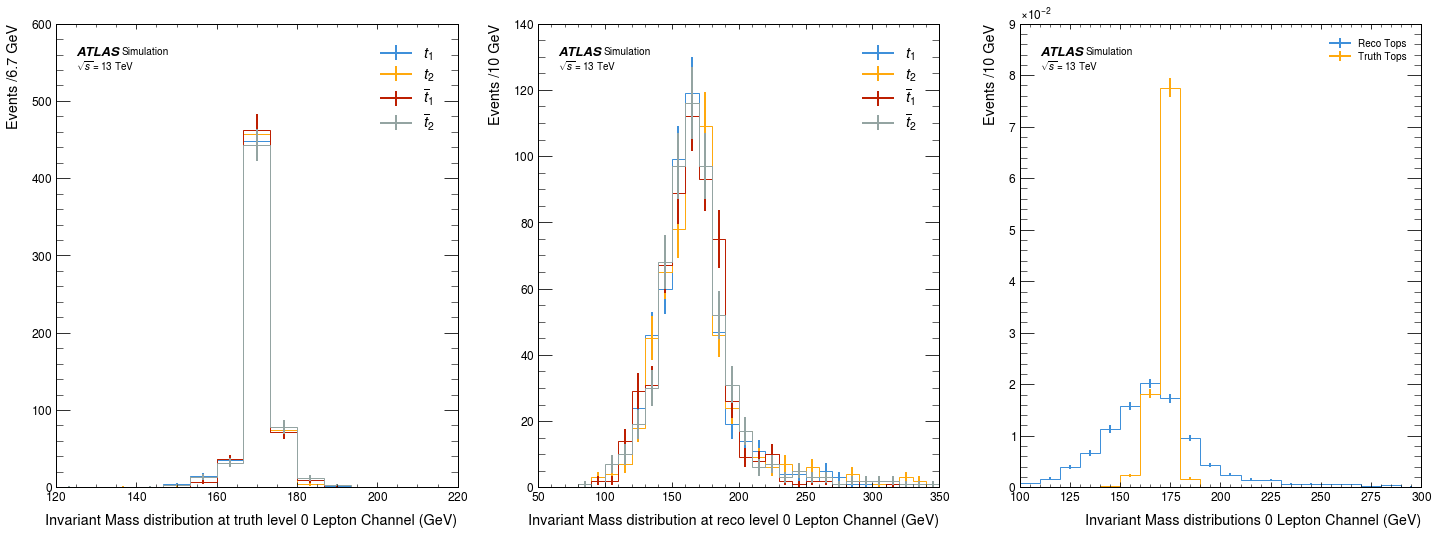

In [75]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([fm_truth_top_1.m,fm_truth_top_2.m,fm_truth_top_3.m,fm_truth_top_4.m], 15, [r'$t_1$', r'$t_2$', r'$\overline{t}_1$', r'$\overline{t}_2$'], ax[0], density = False, x_units='GeV', set_range=(120,220), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distribution at truth level 0 Lepton Channel (GeV)')
ax[0].legend(fontsize=15)
histogram([fm_reco_top_1.m,fm_reco_top_2.m,fm_reco_top_3.m,fm_reco_top_4.m], 30, [r'$t_1$',r'$t_2$',r'$\overline{t}_1$',r'$\overline{t}_2$'], ax[1], density = False, x_units='GeV', print_peak=True, set_range=(50,350))
ax[1].set_xlabel(r'Invariant Mass distribution at reco level 0 Lepton Channel (GeV)')
ax[1].legend(fontsize=15)
histogram([reco_tops_4t_0L,truth_tops_4t_0L], 20, ['Reco Tops', 'Truth Tops'], ax[2], density = True, x_units='GeV', print_peak=True, set_range=(100,300))
ax[2].set_xlabel(r'Invariant Mass distributions 0 Lepton Channel (GeV)')

plt.subplots_adjust(hspace=0.25)
plt.show()


In [ ]:
fully_matched_4t_0L, tm, dm, sm = truth_matching(truth_4t_0L, truth_id_4t_0L, reco_4t_jets_0L, reco_4t_leptons_0L)

fully_matched_ids_4t_0L = fully_matched_4t_0L['truth']['id']

t1_0L = truth_4t_test_0L[:,0]+truth_4t_test_0L[:,4]+truth_4t_test_0L[:,5]
t2_0L = truth_4t_test_0L[:,1]+truth_4t_test_0L[:,6]+truth_4t_test_0L[:,7]
t3_0L = truth_4t_test_0L[:,2]+truth_4t_test_0L[:,8]+truth_4t_test_0L[:,9]
t4_0L = truth_4t_test_0L[:,3]+truth_4t_test_0L[:,10]+truth_4t_test_0L[:,11]

top_1_particles_4t_0L = fully_matched_4t_0L['reco'][(fully_matched_ids_4t_0L==1)|(fully_matched_ids_4t_0L==5)|(fully_matched_ids_4t_0L==6)]
top_2_particles_4t_0L = fully_matched_4t_0L['reco'][(fully_matched_ids_4t_0L==2)|(fully_matched_ids_4t_0L==7)|(fully_matched_ids_4t_0L==8)]
antitop_1_particles_4t_0L = fully_matched_4t_0L['reco'][(fully_matched_ids_4t_0L==3)|(fully_matched_ids_4t_0L==9)|(fully_matched_ids_4t_0L==10)]
antitop_2_particles_4t_0L = fully_matched_4t_0L['reco'][(fully_matched_ids_4t_0L==4)|(fully_matched_ids_4t_0L==11)|(fully_matched_ids_4t_0L==12)]

top_1_4t_0L = ak.sum(top_1_particles_4t_0L, axis=1)
top_2_4t_0L = ak.sum(top_2_particles_4t_0L, axis=1)
antitop_1_4t_0L = ak.sum(antitop_1_particles_4t_0L, axis=1)
antitop_2_4t_0L = ak.sum(antitop_2_particles_4t_0L, axis=1)

reco_tops_4t_0L = ak.concatenate((top_1_4t_0L, top_2_4t_0L, antitop_1_4t_0L, antitop_2_4t_0L))
truth_tops_4t_0L = ak.concatenate((t1_0L, t2_0L, t3_0L, t4_0L))

12
809 9669 38069 60441


In [532]:
len(fully_matched_4t_0L)

533

In [533]:
fully_matched_4t_1L, truth_4t_test_1L, fully_matched_1L = truth_matching(truth_4t_1L, truth_id_4t_1L, reco_4t_jets_1L, reco_4t_leptons_1L)
fully_matched_ids_4t_1L = fully_matched_4t_1L['truth']['id']

fully_matched_events_4t_truth_1L = events_4t_truth_1L[fully_matched_1L]

lepton_locations_1L = ak.argmax(abs(fully_matched_events_4t_truth_1L['W_decay_id']), axis = 1)

matched_lepton_first_1L = fully_matched_4t_1L[lepton_locations_1L == 0]
matched_lepton_second_1L = fully_matched_4t_1L[lepton_locations_1L == 2]
matched_lepton_third_1L = fully_matched_4t_1L[lepton_locations_1L == 4]
matched_lepton_fourth_1L = fully_matched_4t_1L[lepton_locations_1L == 6]

matched_ids_first_1L = fully_matched_ids_4t_1L[lepton_locations_1L == 0]
matched_ids_second_1L = fully_matched_ids_4t_1L[lepton_locations_1L == 2]
matched_ids_third_1L = fully_matched_ids_4t_1L[lepton_locations_1L == 4]
matched_ids_fourth_1L = fully_matched_ids_4t_1L[lepton_locations_1L == 6]

truth_lepton_first_1L = truth_4t_test_1L[lepton_locations_1L == 0]
truth_lepton_second_1L = truth_4t_test_1L[lepton_locations_1L == 2]
truth_lepton_third_1L = truth_4t_test_1L[lepton_locations_1L == 4]
truth_lepton_fourth_1L = truth_4t_test_1L[lepton_locations_1L == 6]

t1_lepton_first_1L = truth_lepton_first_1L[:,0]+truth_lepton_first_1L[:,4]
t2_lepton_first_1L = truth_lepton_first_1L[:,1]+truth_lepton_first_1L[:,5]+truth_lepton_first_1L[:,6]
t3_lepton_first_1L = truth_lepton_first_1L[:,2]+truth_lepton_first_1L[:,7]+truth_lepton_first_1L[:,8]
t4_lepton_first_1L = truth_lepton_first_1L[:,3]+truth_lepton_first_1L[:,9]+truth_lepton_first_1L[:,10]

t1_lepton_second_1L = truth_lepton_second_1L[:,0]+truth_lepton_second_1L[:,4]+truth_lepton_second_1L[:,5]
t2_lepton_second_1L = truth_lepton_second_1L[:,1]+truth_lepton_second_1L[:,6]
t3_lepton_second_1L = truth_lepton_second_1L[:,2]+truth_lepton_second_1L[:,7]+truth_lepton_second_1L[:,8]
t4_lepton_second_1L = truth_lepton_second_1L[:,3]+truth_lepton_second_1L[:,9]+truth_lepton_second_1L[:,10]

t1_lepton_third_1L = truth_lepton_third_1L[:,0]+truth_lepton_third_1L[:,4]+truth_lepton_third_1L[:,5]
t2_lepton_third_1L = truth_lepton_third_1L[:,1]+truth_lepton_third_1L[:,6]+truth_lepton_third_1L[:,7]
t3_lepton_third_1L = truth_lepton_third_1L[:,2]+truth_lepton_third_1L[:,8]
t4_lepton_third_1L = truth_lepton_third_1L[:,3]+truth_lepton_third_1L[:,9]+truth_lepton_third_1L[:,10]

t1_lepton_fourth_1L = truth_lepton_fourth_1L[:,0]+truth_lepton_fourth_1L[:,4]+truth_lepton_fourth_1L[:,5]
t2_lepton_fourth_1L = truth_lepton_fourth_1L[:,1]+truth_lepton_fourth_1L[:,6]+truth_lepton_fourth_1L[:,7]
t3_lepton_fourth_1L = truth_lepton_fourth_1L[:,2]+truth_lepton_fourth_1L[:,8]+truth_lepton_fourth_1L[:,9]
t4_lepton_fourth_1L = truth_lepton_fourth_1L[:,3]+truth_lepton_fourth_1L[:,10]

t1_1L = ak.concatenate((t1_lepton_first_1L,t1_lepton_second_1L, t1_lepton_third_1L, t1_lepton_fourth_1L))
t2_1L = ak.concatenate((t2_lepton_first_1L,t2_lepton_second_1L, t2_lepton_third_1L, t2_lepton_fourth_1L))
t3_1L = ak.concatenate((t3_lepton_first_1L,t3_lepton_second_1L, t3_lepton_third_1L, t3_lepton_fourth_1L))
t4_1L = ak.concatenate((t4_lepton_first_1L,t4_lepton_second_1L, t4_lepton_third_1L, t4_lepton_fourth_1L))

top_1_particles_lepton_first_1L = matched_lepton_first_1L['reco'][(matched_ids_first_1L==1)|(matched_ids_first_1L==5)]
top_2_particles_lepton_first_1L = matched_lepton_first_1L['reco'][(matched_ids_first_1L==2)|(matched_ids_first_1L==6)|(matched_ids_first_1L==7)]
antitop_1_particles_lepton_first_1L = matched_lepton_first_1L['reco'][(matched_ids_first_1L==3)|(matched_ids_first_1L==8)|(matched_ids_first_1L==9)]
antitop_2_particles_lepton_first_1L = matched_lepton_first_1L['reco'][(matched_ids_first_1L==4)|(matched_ids_first_1L==10)|(matched_ids_first_1L==11)]

top_1_particles_lepton_second_1L = matched_lepton_second_1L['reco'][(matched_ids_second_1L==1)|(matched_ids_second_1L==5)|(matched_ids_second_1L==6)]
top_2_particles_lepton_second_1L = matched_lepton_second_1L['reco'][(matched_ids_second_1L==2)|(matched_ids_second_1L==7)]
antitop_1_particles_lepton_second_1L = matched_lepton_second_1L['reco'][(matched_ids_second_1L==3)|(matched_ids_second_1L==8)|(matched_ids_second_1L==9)]
antitop_2_particles_lepton_second_1L = matched_lepton_second_1L['reco'][(matched_ids_second_1L==4)|(matched_ids_second_1L==10)|(matched_ids_second_1L==11)]

top_1_particles_lepton_third_1L = matched_lepton_third_1L['reco'][(matched_ids_third_1L==1)|(matched_ids_third_1L==5)|(matched_ids_third_1L==6)]
top_2_particles_lepton_third_1L = matched_lepton_third_1L['reco'][(matched_ids_third_1L==2)|(matched_ids_third_1L==7)|(matched_ids_third_1L==8)]
antitop_1_particles_lepton_third_1L = matched_lepton_third_1L['reco'][(matched_ids_third_1L==3)|(matched_ids_third_1L==9)]
antitop_2_particles_lepton_third_1L = matched_lepton_third_1L['reco'][(matched_ids_third_1L==4)|(matched_ids_third_1L==10)|(matched_ids_third_1L==11)]

top_1_particles_lepton_fourth_1L = matched_lepton_fourth_1L['reco'][(matched_ids_fourth_1L==1)|(matched_ids_fourth_1L==5)|(matched_ids_fourth_1L==6)]
top_2_particles_lepton_fourth_1L = matched_lepton_fourth_1L['reco'][(matched_ids_fourth_1L==2)|(matched_ids_fourth_1L==7)|(matched_ids_fourth_1L==8)]
antitop_1_particles_lepton_fourth_1L = matched_lepton_fourth_1L['reco'][(matched_ids_fourth_1L==3)|(matched_ids_fourth_1L==9)|(matched_ids_fourth_1L==10)]
antitop_2_particles_lepton_fourth_1L = matched_lepton_fourth_1L['reco'][(matched_ids_fourth_1L==4)|(matched_ids_fourth_1L==11)]

top_1_particles_4t_1L = ak.concatenate((top_1_particles_lepton_first_1L, top_1_particles_lepton_second_1L, top_1_particles_lepton_third_1L, top_1_particles_lepton_fourth_1L))
top_2_particles_4t_1L = ak.concatenate((top_2_particles_lepton_first_1L, top_2_particles_lepton_second_1L, top_2_particles_lepton_third_1L, top_2_particles_lepton_fourth_1L))
antitop_1_particles_4t_1L = ak.concatenate((antitop_1_particles_lepton_first_1L, antitop_1_particles_lepton_second_1L, antitop_1_particles_lepton_third_1L, antitop_1_particles_lepton_fourth_1L))
antitop_2_particles_4t_1L = ak.concatenate((antitop_2_particles_lepton_first_1L, antitop_2_particles_lepton_second_1L, antitop_2_particles_lepton_third_1L, antitop_2_particles_lepton_fourth_1L))

top_1_4t_1L = ak.sum(top_1_particles_4t_1L, axis=1)
top_2_4t_1L = ak.sum(top_2_particles_4t_1L, axis=1)
antitop_1_4t_1L = ak.sum(antitop_1_particles_4t_1L, axis=1)
antitop_2_4t_1L = ak.sum(antitop_2_particles_4t_1L, axis=1)

reco_tops_4t_1L = ak.concatenate((top_1_4t_1L, top_2_4t_1L, antitop_1_4t_1L, antitop_2_4t_1L))
truth_tops_4t_1L = ak.concatenate((t1_1L, t2_1L, t3_1L, t4_1L))

11


In [596]:
fully_matched_leptons_1L = fully_matched_4t_1L[(fully_matched_4t_1L['reco'].m == 0.1057)|(fully_matched_4t_1L['reco'].m == 0.511e-3)]

In [599]:
fully_matched_leptons_1L['reco'].m

<Array [[], [], [], ..., [0.106], [], [0.000511]] type='768 * var * float32'>

In [535]:
fully_matched_4t_2L, truth_4t_test_2L, fully_matched_2L = truth_matching(truth_4t_2L, truth_id_4t_2L, reco_4t_jets_2L, reco_4t_leptons_2L)
fully_matched_ids_4t_2L = fully_matched_4t_2L['truth']['id']

fully_matched_events_4t_truth_2L = events_4t_truth_2L[fully_matched_2L]

lepton_indices = ak.sort(ak.argsort(abs(fully_matched_events_4t_truth_2L['W_decay_id']), axis = 1, ascending=False)[:,:2], axis=1)

matched_01_2L, truth_lepton_01_2L = fully_matched_4t_2L[(lepton_indices[:,0]==0)&(lepton_indices[:,1]==1)], truth_4t_test_2L[(lepton_indices[:,0]==0)&(lepton_indices[:,1]==1)]
t1_01_2L, t2_01_2L, t3_01_2L, t4_01_2L = truth_lepton_01_2L[:,0]+truth_lepton_01_2L[:,4], truth_lepton_01_2L[:,1]+truth_lepton_01_2L[:,5], truth_lepton_01_2L[:,2]+truth_lepton_01_2L[:,6]+truth_lepton_01_2L[:,7], truth_lepton_01_2L[:,3]+truth_lepton_01_2L[:,8]+truth_lepton_01_2L[:,9]
t1_01_particles_2L = matched_01_2L['reco'][(matched_01_2L['truth']['id']==1)|(matched_01_2L['truth']['id']==5)]
t2_01_particles_2L = matched_01_2L['reco'][(matched_01_2L['truth']['id']==2)|(matched_01_2L['truth']['id']==6)]
t3_01_particles_2L = matched_01_2L['reco'][(matched_01_2L['truth']['id']==3)|(matched_01_2L['truth']['id']==7)|(matched_01_2L['truth']['id']==8)]
t4_01_particles_2L = matched_01_2L['reco'][(matched_01_2L['truth']['id']==4)|(matched_01_2L['truth']['id']==9)|(matched_01_2L['truth']['id']==10)]

matched_03_2L, truth_lepton_03_2L = fully_matched_4t_2L[(lepton_indices[:,0]==0)&(lepton_indices[:,1]==3)], truth_4t_test_2L[(lepton_indices[:,0]==0)&(lepton_indices[:,1]==3)]
t1_03_2L, t2_03_2L, t3_03_2L, t4_03_2L = truth_lepton_03_2L[:,0]+truth_lepton_03_2L[:,4], truth_lepton_03_2L[:,1]+truth_lepton_03_2L[:,5]+truth_lepton_03_2L[:,6], truth_lepton_03_2L[:,2]+truth_lepton_03_2L[:,7], truth_lepton_03_2L[:,3]+truth_lepton_03_2L[:,8]+truth_lepton_03_2L[:,9]
t1_03_particles_2L = matched_03_2L['reco'][(matched_03_2L['truth']['id']==1)|(matched_03_2L['truth']['id']==5)]
t2_03_particles_2L = matched_03_2L['reco'][(matched_03_2L['truth']['id']==2)|(matched_03_2L['truth']['id']==6)|(matched_03_2L['truth']['id']==7)]
t3_03_particles_2L = matched_03_2L['reco'][(matched_03_2L['truth']['id']==3)|(matched_03_2L['truth']['id']==8)]
t4_03_particles_2L = matched_03_2L['reco'][(matched_03_2L['truth']['id']==4)|(matched_03_2L['truth']['id']==9)|(matched_03_2L['truth']['id']==10)]

matched_05_2L, truth_lepton_05_2L = fully_matched_4t_2L[(lepton_indices[:,0]==0)&(lepton_indices[:,1]==5)], truth_4t_test_2L[(lepton_indices[:,0]==0)&(lepton_indices[:,1]==5)]
t1_05_2L, t2_05_2L, t3_05_2L, t4_05_2L = truth_lepton_05_2L[:,0]+truth_lepton_05_2L[:,4], truth_lepton_05_2L[:,1]+truth_lepton_05_2L[:,5]+truth_lepton_05_2L[:,6], truth_lepton_05_2L[:,2]+truth_lepton_05_2L[:,7]+truth_lepton_05_2L[:,8], truth_lepton_05_2L[:,3]+truth_lepton_05_2L[:,9]
t1_05_particles_2L = matched_05_2L['reco'][(matched_05_2L['truth']['id']==1)|(matched_05_2L['truth']['id']==5)]
t2_05_particles_2L = matched_05_2L['reco'][(matched_05_2L['truth']['id']==2)|(matched_05_2L['truth']['id']==6)|(matched_05_2L['truth']['id']==7)]
t3_05_particles_2L = matched_05_2L['reco'][(matched_05_2L['truth']['id']==3)|(matched_05_2L['truth']['id']==8)|(matched_05_2L['truth']['id']==9)]
t4_05_particles_2L = matched_05_2L['reco'][(matched_05_2L['truth']['id']==4)|(matched_05_2L['truth']['id']==10)]

matched_23_2L, truth_lepton_23_2L = fully_matched_4t_2L[(lepton_indices[:,0]==2)&(lepton_indices[:,1]==3)], truth_4t_test_2L[(lepton_indices[:,0]==2)&(lepton_indices[:,1]==3)]
t1_23_2L, t2_23_2L, t3_23_2L, t4_23_2L = truth_lepton_23_2L[:,0]+truth_lepton_23_2L[:,4]+truth_lepton_23_2L[:,5], truth_lepton_23_2L[:,1]+truth_lepton_23_2L[:,6], truth_lepton_23_2L[:,2]+truth_lepton_23_2L[:,7], truth_lepton_23_2L[:,3]+truth_lepton_23_2L[:,8]+truth_lepton_23_2L[:,9]
t1_23_particles_2L = matched_23_2L['reco'][(matched_23_2L['truth']['id']==1)|(matched_23_2L['truth']['id']==5)|(matched_23_2L['truth']['id']==6)]
t2_23_particles_2L = matched_23_2L['reco'][(matched_23_2L['truth']['id']==2)|(matched_23_2L['truth']['id']==7)]
t3_23_particles_2L = matched_23_2L['reco'][(matched_23_2L['truth']['id']==3)|(matched_23_2L['truth']['id']==8)]
t4_23_particles_2L = matched_23_2L['reco'][(matched_23_2L['truth']['id']==4)|(matched_23_2L['truth']['id']==9)|(matched_23_2L['truth']['id']==10)]

matched_25_2L, truth_lepton_25_2L = fully_matched_4t_2L[(lepton_indices[:,0]==2)&(lepton_indices[:,1]==5)], truth_4t_test_2L[(lepton_indices[:,0]==2)&(lepton_indices[:,1]==5)]
t1_25_2L, t2_25_2L, t3_25_2L, t4_25_2L = truth_lepton_25_2L[:,0]+truth_lepton_25_2L[:,4]+truth_lepton_25_2L[:,5], truth_lepton_25_2L[:,1]+truth_lepton_25_2L[:,6], truth_lepton_25_2L[:,2]+truth_lepton_25_2L[:,7]+truth_lepton_25_2L[:,8], truth_lepton_25_2L[:,3]+truth_lepton_25_2L[:,9]
t1_25_particles_2L = matched_25_2L['reco'][(matched_25_2L['truth']['id']==1)|(matched_25_2L['truth']['id']==5)|(matched_25_2L['truth']['id']==6)]
t2_25_particles_2L = matched_25_2L['reco'][(matched_25_2L['truth']['id']==2)|(matched_25_2L['truth']['id']==7)]
t3_25_particles_2L = matched_25_2L['reco'][(matched_25_2L['truth']['id']==3)|(matched_25_2L['truth']['id']==8)|(matched_25_2L['truth']['id']==9)]
t4_25_particles_2L = matched_25_2L['reco'][(matched_25_2L['truth']['id']==4)|(matched_25_2L['truth']['id']==10)]

matched_45_2L, truth_lepton_45_2L = fully_matched_4t_2L[lepton_indices[:,0]==4], truth_4t_test_2L[lepton_indices[:,0]==4]
t1_45_2L, t2_45_2L, t3_45_2L, t4_45_2L = truth_lepton_45_2L[:,0]+truth_lepton_45_2L[:,4]+truth_lepton_45_2L[:,5], truth_lepton_45_2L[:,1]+truth_lepton_45_2L[:,6]+truth_lepton_45_2L[:,7], truth_lepton_45_2L[:,2]+truth_lepton_45_2L[:,8], truth_lepton_45_2L[:,3]+truth_lepton_45_2L[:,9]
t1_45_particles_2L = matched_45_2L['reco'][(matched_45_2L['truth']['id']==1)|(matched_45_2L['truth']['id']==5)|(matched_45_2L['truth']['id']==6)]
t2_45_particles_2L = matched_45_2L['reco'][(matched_45_2L['truth']['id']==2)|(matched_45_2L['truth']['id']==7)|(matched_45_2L['truth']['id']==8)]
t3_45_particles_2L = matched_45_2L['reco'][(matched_45_2L['truth']['id']==3)|(matched_45_2L['truth']['id']==9)]
t4_45_particles_2L = matched_45_2L['reco'][(matched_45_2L['truth']['id']==4)|(matched_45_2L['truth']['id']==10)]

t1_4t_2L = ak.concatenate((t1_01_2L,t1_03_2L, t1_05_2L, t1_23_2L, t1_25_2L, t1_45_2L))
t2_4t_2L = ak.concatenate((t2_01_2L,t2_03_2L, t2_05_2L, t2_23_2L, t2_25_2L, t2_45_2L))
t3_4t_2L = ak.concatenate((t3_01_2L,t3_03_2L, t3_05_2L, t3_23_2L, t3_25_2L, t3_45_2L))
t4_4t_2L = ak.concatenate((t4_01_2L,t4_03_2L, t4_05_2L, t4_23_2L, t4_25_2L, t4_45_2L))

top1_particles_2L = ak.concatenate((t1_01_particles_2L, t1_03_particles_2L, t1_05_particles_2L, t1_23_particles_2L, t1_25_particles_2L, t1_45_particles_2L))
top2_particles_2L = ak.concatenate((t2_01_particles_2L, t2_03_particles_2L, t2_05_particles_2L, t2_23_particles_2L, t2_25_particles_2L, t2_45_particles_2L))
top3_particles_2L = ak.concatenate((t3_01_particles_2L, t3_03_particles_2L, t3_05_particles_2L, t3_23_particles_2L, t3_25_particles_2L, t3_45_particles_2L))
top4_particles_2L = ak.concatenate((t4_01_particles_2L, t4_03_particles_2L, t4_05_particles_2L, t4_23_particles_2L, t4_25_particles_2L, t4_45_particles_2L))

top1_4t_2L = ak.sum(top1_particles_2L, axis=1)
top2_4t_2L = ak.sum(top2_particles_2L, axis=1)
top3_4t_2L = ak.sum(top3_particles_2L, axis=1)
top4_4t_2L = ak.sum(top4_particles_2L, axis=1)

reco_tops_4t_2L = ak.concatenate((top1_4t_2L, top2_4t_2L, top3_4t_2L, top4_4t_2L))
truth_tops_4t_2L = ak.concatenate((t1_4t_2L, t2_4t_2L, t3_4t_2L, t4_4t_2L))

10


In [536]:
len(fully_matched_4t_2L)

379

Peak bin center for $t_1$: 170.00 GeV
Peak bin center for $t_2$: 170.00 GeV
Peak bin center for $\overline{t}_1$: 170.00 GeV
Peak bin center for $\overline{t}_2$: 170.00 GeV
Peak bin center for $t_1$: 165.00 GeV
Peak bin center for $t_2$: 165.00 GeV
Peak bin center for $\overline{t}_1$: 165.00 GeV
Peak bin center for $\overline{t}_2$: 165.00 GeV
Peak bin center for Reco Tops: 165.00 GeV
Peak bin center for Truth Tops: 175.00 GeV


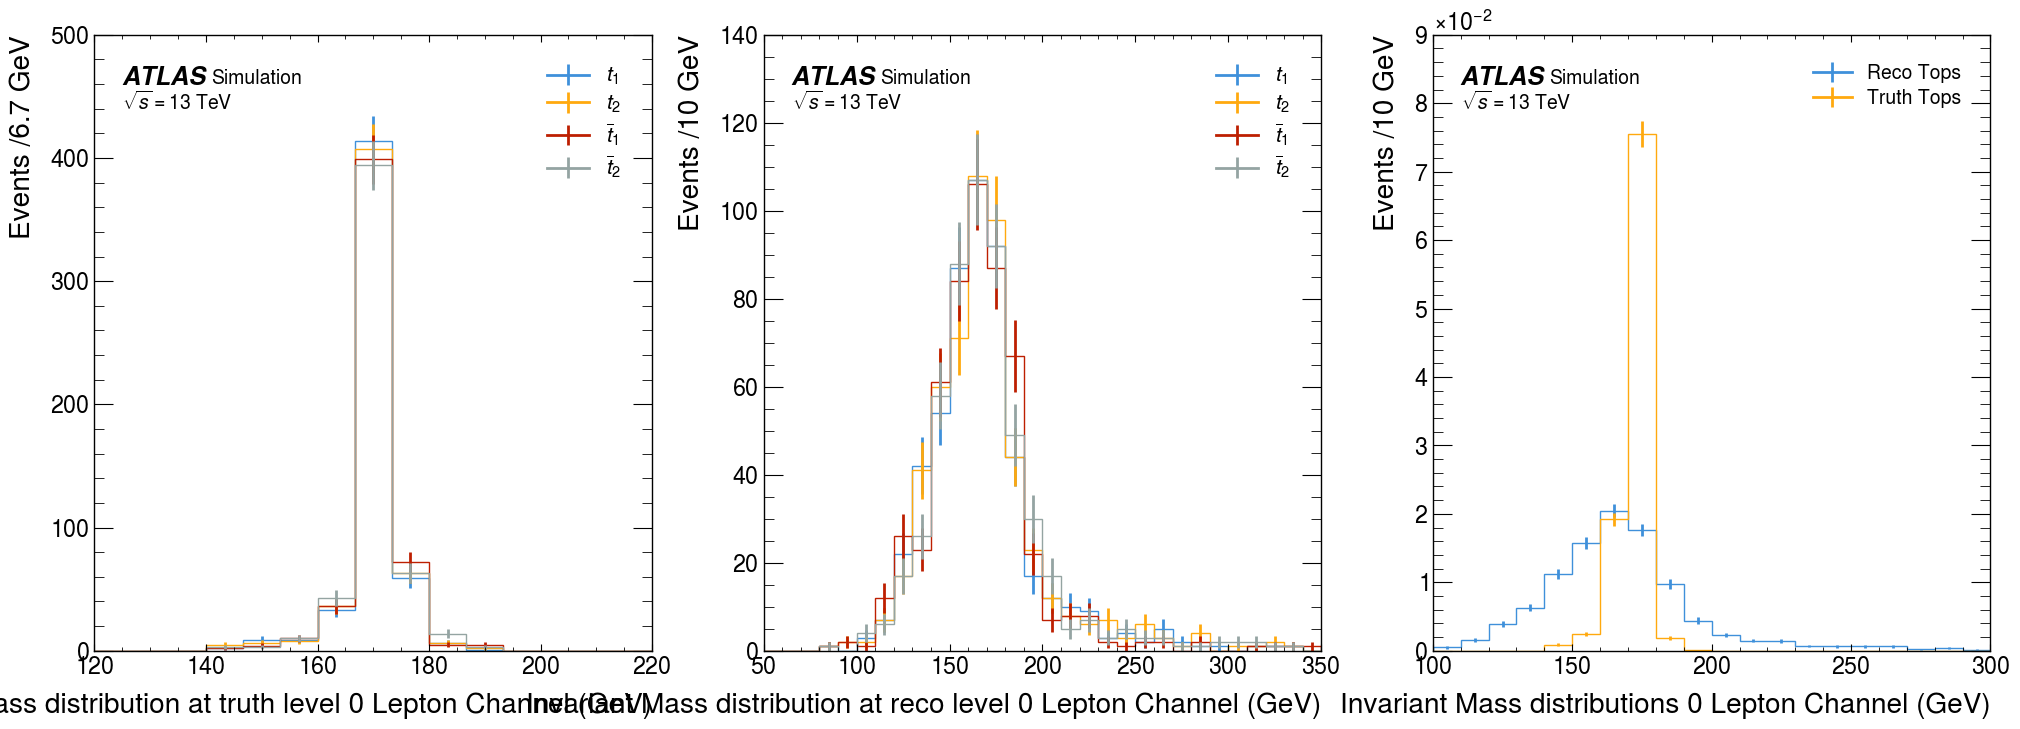

Peak bin center for $t_1$: 170.00 GeV
Peak bin center for $t_2$: 170.00 GeV
Peak bin center for $\overline{t}_1$: 170.00 GeV
Peak bin center for $\overline{t}_2$: 170.00 GeV
Peak bin center for $t_1$: 165.00 GeV
Peak bin center for $t_2$: 165.00 GeV
Peak bin center for $\overline{t}_1$: 175.00 GeV
Peak bin center for $\overline{t}_2$: 165.00 GeV
Peak bin center for Reco Tops: 163.33 GeV
Peak bin center for Truth Tops: 170.00 GeV


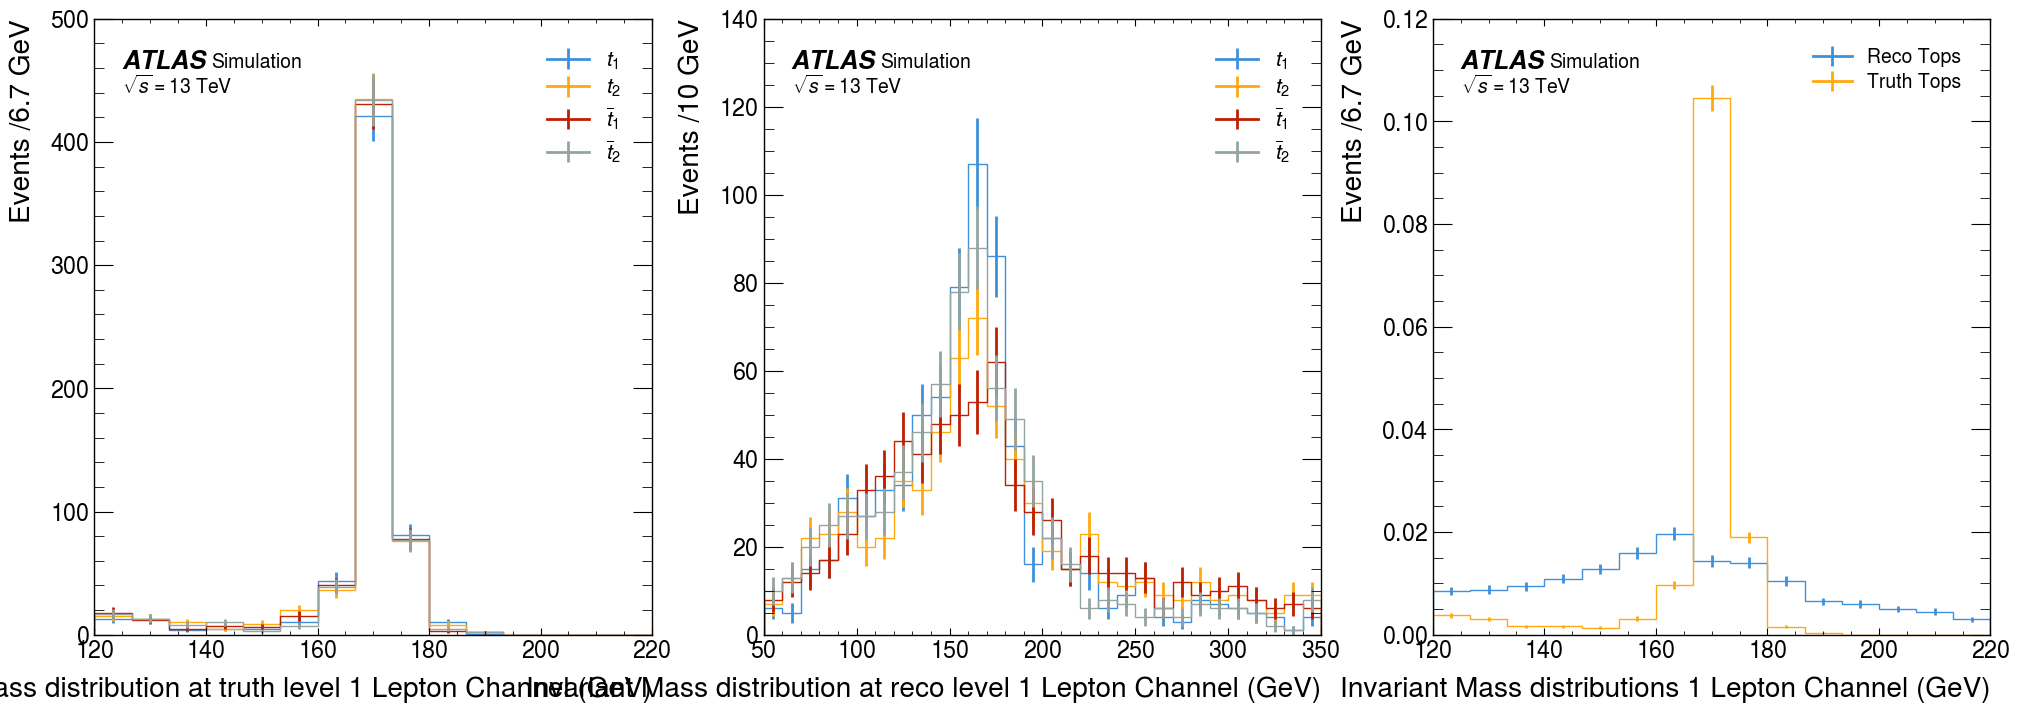

Peak bin center for $t_1$: 175.00 GeV
Peak bin center for $t_2$: 175.00 GeV
Peak bin center for $\overline{t}_1$: 175.00 GeV
Peak bin center for $\overline{t}_2$: 175.00 GeV
Peak bin center for $t_1$: 125.00 GeV
Peak bin center for $t_2$: 145.00 GeV
Peak bin center for $\overline{t}_1$: 165.00 GeV
Peak bin center for $\overline{t}_2$: 125.00 GeV
Peak bin center for Reco Tops: 125.00 GeV
Peak bin center for Truth Tops: 175.00 GeV


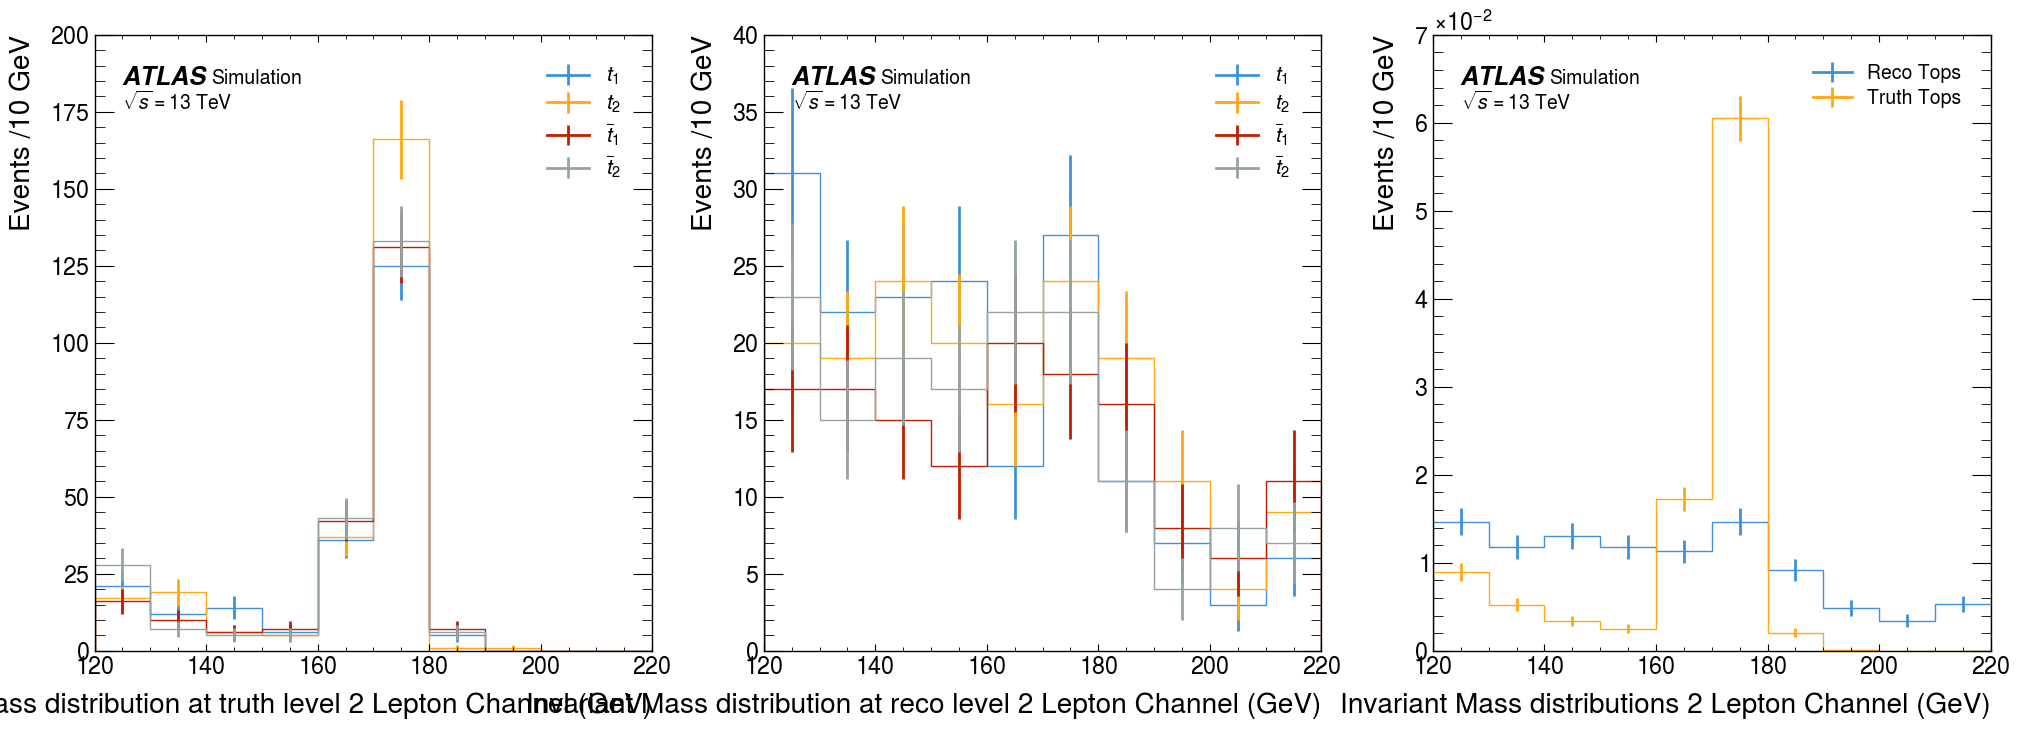

In [518]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([t1_0L.m, t2_0L.m, t3_0L.m, t4_0L.m], 15, [r'$t_1$', r'$t_2$', r'$\overline{t}_1$', r'$\overline{t}_2$'], ax[0], density = False, x_units='GeV', set_range=(120,220), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distribution at truth level 0 Lepton Channel (GeV)')
ax[0].legend(fontsize=15)
histogram([top_1_4t_0L.m, top_2_4t_0L.m, antitop_1_4t_0L.m, antitop_2_4t_0L.m], 30, [r'$t_1$',r'$t_2$',r'$\overline{t}_1$',r'$\overline{t}_2$'], ax[1], density = False, x_units='GeV', print_peak=True, set_range=(50,350))
ax[1].set_xlabel(r'Invariant Mass distribution at reco level 0 Lepton Channel (GeV)')
ax[1].legend(fontsize=15)
histogram([reco_tops_4t_0L.m,truth_tops_4t_0L.m], 20, ['Reco Tops', 'Truth Tops'], ax[2], density = True, x_units='GeV', print_peak=True, set_range=(100,300))
ax[2].set_xlabel(r'Invariant Mass distributions 0 Lepton Channel (GeV)')

plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([t1_1L.m, t2_1L.m, t3_1L.m, t4_1L.m], 15, [r'$t_1$', r'$t_2$', r'$\overline{t}_1$', r'$\overline{t}_2$'], ax[0], density = False, x_units='GeV', set_range=(120,220), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distribution at truth level 1 Lepton Channel (GeV)')
ax[0].legend(fontsize=15)
histogram([top_1_4t_1L.m, top_2_4t_1L.m, antitop_1_4t_1L.m, antitop_2_4t_1L.m], 30, [r'$t_1$',r'$t_2$',r'$\overline{t}_1$',r'$\overline{t}_2$'], ax[1], density = False, x_units='GeV', print_peak=True, set_range=(50,350))
ax[1].set_xlabel(r'Invariant Mass distribution at reco level 1 Lepton Channel (GeV)')
ax[1].legend(fontsize=15)
histogram([reco_tops_4t_1L.m,truth_tops_4t_1L.m], 15, ['Reco Tops', 'Truth Tops'], ax[2], density = True, x_units='GeV', print_peak=True, set_range=(120,220))
ax[2].set_xlabel(r'Invariant Mass distributions 1 Lepton Channel (GeV)')

plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([t1_4t_2L.m, t2_4t_2L.m, t3_4t_2L.m, t4_4t_2L.m], 10, [r'$t_1$', r'$t_2$', r'$\overline{t}_1$', r'$\overline{t}_2$'], ax[0], density = False, x_units='GeV', set_range=(120,220), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distribution at truth level 2 Lepton Channel (GeV)')
ax[0].legend(fontsize=15)
histogram([top1_4t_2L.m, top2_4t_2L.m, top3_4t_2L.m, top4_4t_2L.m], 10, [r'$t_1$',r'$t_2$',r'$\overline{t}_1$',r'$\overline{t}_2$'], ax[1], density = False, x_units='GeV', print_peak=True, set_range=(120,220))
ax[1].set_xlabel(r'Invariant Mass distribution at reco level 2 Lepton Channel (GeV)')
ax[1].legend(fontsize=15)
histogram([reco_tops_4t_2L.m,truth_tops_4t_2L.m], 10, ['Reco Tops', 'Truth Tops'], ax[2], density = True, x_units='GeV', print_peak=True, set_range=(120,220))
ax[2].set_xlabel(r'Invariant Mass distributions 2 Lepton Channel (GeV)')

plt.subplots_adjust(hspace=0.25)
plt.show()



### 3 Top Matching

In [511]:
tree3j = uproot.open(directory + "tttj_skimmed_nov14.root")
tree3j_truth = tree3j['Truth;1']
tree3j_reco = tree3j['Reco;1']

events_3tj_truth = tree3j_truth.arrays(['b_id', 'b_pt', 'b_eta', 'b_phi', 'b_e', 'b_mass', 'W_decay_id', 'W_decay_pt', 'W_decay_eta', 'W_decay_phi', 'W_decay_e', 'W_decay_mass'])
events_3tj_partonic = tree3j_truth.arrays(['top_pt', 'top_eta', 'top_phi', 'top_e', 'top_mass', 'top_id', 'W_pt', 'W_eta', 'W_phi', 'W_e', 'W_mass', 'W_id',])
events_3tj_reco = tree3j_reco.arrays(['jet_pt', 'jet_eta', 'jet_phi', 'jet_mass', 'jet_btag', 'el_pt', 'el_eta', 'el_phi', 'el_charge', 'mu_pt','mu_eta', 'mu_phi', 'mu_charge', 'met_met', 'met_eta', 'met_phi'])
events_3tj_reco['el_mass'] = 0.511e-3 * np.ones_like(events_3tj_reco['el_pt'])
events_3tj_reco['mu_mass'] = 0.1057 * np.ones_like(events_3tj_reco['mu_pt'])

print(len(events_3tj_truth))

x = events_3tj_truth['W_decay_id'][(events_3tj_truth['W_decay_id']==15)|(events_3tj_truth['W_decay_id']==-15)]
events_3tj_reco = events_3tj_reco[ak.num(x)==0]
events_3tj_partonic = events_3tj_partonic[ak.num(x)==0]
events_3tj_truth = events_3tj_truth[ak.num(x)==0]

good_events = (ak.num(events_3tj_truth['b_id'])==3)

print(len(events_3tj_truth))

jet_pt_3tj = events_3tj_reco['jet_pt'][(events_3tj_reco['jet_eta']<2.5) & (events_3tj_reco['jet_eta']>-2.5)]
jet_eta_3tj = events_3tj_reco['jet_eta'][(events_3tj_reco['jet_eta']<2.5) & (events_3tj_reco['jet_eta']>-2.5)]
jet_phi_3tj = events_3tj_reco['jet_phi'][(events_3tj_reco['jet_eta']<2.5) & (events_3tj_reco['jet_eta']>-2.5)]
jet_mass_3tj = events_3tj_reco['jet_mass'][(events_3tj_reco['jet_eta']<2.5) & (events_3tj_reco['jet_eta']>-2.5)]

electron_pt_3tj = events_3tj_reco['el_pt'][(events_3tj_reco['el_pt'] > 15) & (events_3tj_reco['el_eta'] < 2.47) & (events_3tj_reco['el_eta'] > -2.47)]
electron_eta_3tj = events_3tj_reco['el_eta'][(events_3tj_reco['el_pt'] > 15) & (events_3tj_reco['el_eta'] < 2.47) & (events_3tj_reco['el_eta'] > -2.47)]
electron_phi_3tj = events_3tj_reco['el_phi'][(events_3tj_reco['el_pt'] > 15) & (events_3tj_reco['el_eta'] < 2.47) & (events_3tj_reco['el_eta'] > -2.47)]
electron_mass_3tj = events_3tj_reco['el_mass'][(events_3tj_reco['el_pt'] > 15) & (events_3tj_reco['el_eta'] < 2.47) & (events_3tj_reco['el_eta'] > -2.47)]

muon_pt_3tj = events_3tj_reco['mu_pt'][(events_3tj_reco['mu_pt']>15) & (events_3tj_reco['mu_eta']<2.5) & (events_3tj_reco['mu_eta']>-2.5)]
muon_eta_3tj = events_3tj_reco['mu_eta'][(events_3tj_reco['mu_pt']>15) & (events_3tj_reco['mu_eta']<2.5) & (events_3tj_reco['mu_eta']>-2.5)]
muon_phi_3tj = events_3tj_reco['mu_phi'][(events_3tj_reco['mu_pt']>15) & (events_3tj_reco['mu_eta']<2.5) & (events_3tj_reco['mu_eta']>-2.5)]
muon_mass_3tj = events_3tj_reco['mu_mass'][(events_3tj_reco['mu_pt']>15) & (events_3tj_reco['mu_eta']<2.5) & (events_3tj_reco['mu_eta']>-2.5)]

lepton_pt_3tj = ak.concatenate((muon_pt_3tj,electron_pt_3tj), axis=1)
lepton_eta_3tj = ak.concatenate((muon_eta_3tj,electron_eta_3tj), axis=1)
lepton_phi_3tj = ak.concatenate((muon_phi_3tj,electron_phi_3tj), axis=1)
lepton_mass_3tj = ak.concatenate((muon_mass_3tj,electron_mass_3tj), axis=1)

reco_pt_3tj = ak.concatenate((jet_pt_3tj,lepton_pt_3tj), axis=1)
reco_eta_3tj = ak.concatenate((jet_eta_3tj,lepton_eta_3tj), axis=1)
reco_phi_3tj = ak.concatenate((jet_phi_3tj,lepton_phi_3tj), axis=1)
reco_mass_3tj = ak.concatenate((jet_mass_3tj,lepton_mass_3tj), axis=1)

b_pt_3tj = events_3tj_truth['b_pt']
b_eta_3tj = events_3tj_truth['b_eta']
b_phi_3tj = events_3tj_truth['b_phi']
b_mass_3tj = events_3tj_truth['b_mass']
b_e_3tj = events_3tj_truth['b_e']
b_id_3tj = events_3tj_truth['b_id']

w_decay_pt_3tj = events_3tj_truth['W_decay_pt']
w_decay_eta_3tj = events_3tj_truth['W_decay_eta']
w_decay_phi_3tj = events_3tj_truth['W_decay_phi']
w_decay_mass_3tj = events_3tj_truth['W_decay_mass']
w_decay_e_3tj = events_3tj_truth['W_decay_e']
w_decay_id_3tj = events_3tj_truth['W_decay_id']

truth_pt_3tj = ak.concatenate((b_pt_3tj,w_decay_pt_3tj), axis=1)
truth_eta_3tj = ak.concatenate((b_eta_3tj,w_decay_eta_3tj), axis=1)
truth_phi_3tj = ak.concatenate((b_phi_3tj,w_decay_phi_3tj), axis=1)
truth_mass_3tj = ak.concatenate((b_mass_3tj,w_decay_mass_3tj), axis=1)
truth_e_3tj = ak.concatenate((b_e_3tj,w_decay_e_3tj), axis=1)
truth_id_3tj = ak.concatenate((b_id_3tj,w_decay_id_3tj), axis=1)

reco_3tj = vector.zip({'pt':reco_pt_3tj,'eta':reco_eta_3tj,'phi':reco_phi_3tj,'mass':reco_mass_3tj})
truth_3tj = vector.zip({'pt':truth_pt_3tj,'eta':truth_eta_3tj,'phi':truth_phi_3tj,'mass':truth_mass_3tj})

reco_3tj_leptons = vector.zip({'pt':lepton_pt_3tj,'eta':lepton_eta_3tj,'phi':lepton_phi_3tj,'mass':lepton_mass_3tj})
reco_3tj_jets = vector.zip({'pt':jet_pt_3tj,'eta':jet_eta_3tj,'phi':jet_phi_3tj,'mass':jet_mass_3tj})

truth_3tj = truth_3tj[(ak.num(reco_3tj)!=0)]
good_events = good_events[(ak.num(reco_3tj)!=0)]
reco_3tj = reco_3tj[(ak.num(reco_3tj)!=0)]
reco_3tj_leptons = reco_3tj_leptons[(ak.num(reco_3tj)!=0)]
reco_3tj_jets = reco_3tj_jets[(ak.num(reco_3tj)!=0)]

truth_3tj = ak.concatenate((truth_3tj[good_events],truth_3tj[~good_events][:,1:]))
reco_3tj = ak.concatenate((reco_3tj[good_events],reco_3tj[~good_events]))
reco_3tj_leptons = ak.concatenate((reco_3tj_leptons[good_events],reco_3tj_leptons[~good_events]))
reco_3tj_jets = ak.concatenate((reco_3tj_jets[good_events],reco_3tj_jets[~good_events]))
truth_id_3tj = ak.concatenate((truth_id_3tj[good_events],truth_id_3tj[~good_events][:,1:]))

482032
340763


In [485]:
fully_matched_3tj, truth_3tj_test, _ = truth_matching(truth_3tj, truth_id_3tj, reco_3tj_jets, reco_3tj_leptons)

fully_matched_ids_3tj = fully_matched_3tj['truth']['id']

t1 = truth_3tj_test[:,0]+truth_3tj_test[:,3]+truth_3tj_test[:,4]
t2 = truth_3tj_test[:,1]+truth_3tj_test[:,5]+truth_3tj_test[:,6]
t3 = truth_3tj_test[:,2]+truth_3tj_test[:,7]+truth_3tj_test[:,8]

top_1_particles_3tj = fully_matched_3tj['reco'][(fully_matched_ids_3tj==1)|(fully_matched_ids_3tj==4)|(fully_matched_ids_3tj==5)]
top_2_particles_3tj = fully_matched_3tj['reco'][(fully_matched_ids_3tj==2)|(fully_matched_ids_3tj==6)|(fully_matched_ids_3tj==7)]
top_3_particles_3tj = fully_matched_3tj['reco'][(fully_matched_ids_3tj==3)|(fully_matched_ids_3tj==8)|(fully_matched_ids_3tj==9)]

top_1_3tj = ak.sum(top_1_particles_3tj, axis=1)
top_2_3tj = ak.sum(top_2_particles_3tj, axis=1)
top_3_3tj = ak.sum(top_3_particles_3tj, axis=1)


9


976

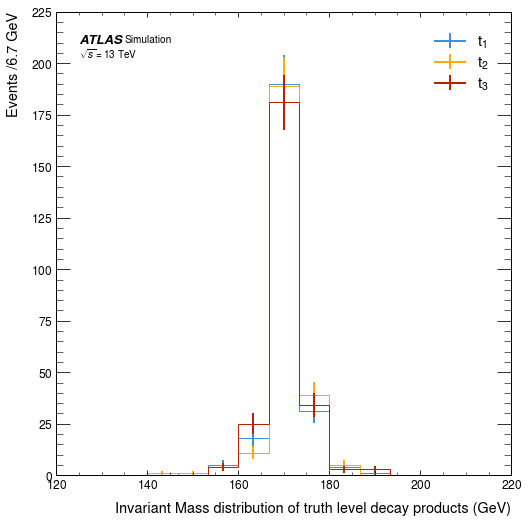

In [490]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
histogram([t1.m, t2.m, t3.m], 15, [r't$_1$', r't$_2$', r't$_3$'], ax, density = False, x_units='GeV', set_range=(120,220))
ax.set_xlabel(r'Invariant Mass distribution of truth level decay products (GeV)')
ax.legend(fontsize=15)
plt.subplots_adjust(hspace=0.25)

plt.show()

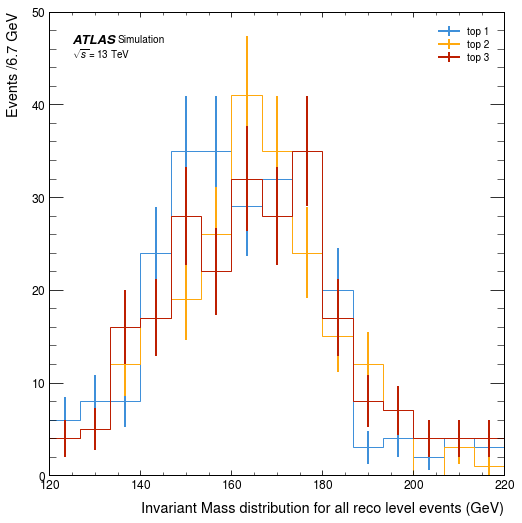

In [491]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
histogram([top_1_3tj.m, top_2_3tj.m, top_3_3tj.m], 15, ['top 1', 'top 2', 'top 3'], ax, density = False, x_units='GeV', set_range=(120,220))
ax.set_xlabel(r'Invariant Mass distribution for all reco level events (GeV)')
plt.subplots_adjust(hspace=0.25)
plt.show()

Peak bin center for Reco Tops: 167.50 GeV
Peak bin center for Truth Tops: 172.50 GeV


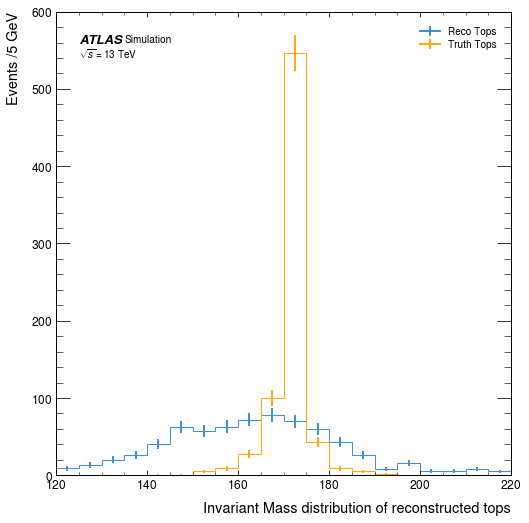

In [492]:
reco_tops_3tj = ak.concatenate((top_1_3tj, top_2_3tj, top_3_3tj))
truth_tops_3tj = ak.concatenate((t1, t2, t3))

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
histogram([reco_tops_3tj.m,truth_tops_3tj.m], 20, ['Reco Tops', 'Truth Tops'], ax, density = False, x_units='GeV', print_peak=True, set_range=(120,220))
ax.set_xlabel(r'Invariant Mass distribution of reconstructed tops')
plt.subplots_adjust(hspace=0.25)
plt.show()

In [ ]:
tree3W = uproot.open(directory + "tttW_withtruth_nov13.root")
tree3W_truth = tree3W['Truth;1']
tree3W_reco = tree3W['Reco;1']

events_3tW_truth = tree3W_truth.arrays(['b_id', 'b_pt', 'b_eta', 'b_phi', 'b_e', 'b_mass', 'W_decay_id', 'W_decay_pt', 'W_decay_eta', 'W_decay_phi', 'W_decay_e', 'W_decay_mass'])

events_3tW_truth['b_id'][ak.num(events_3tW_truth['b_id'])!=3]

<Array [] type='0 * var * int32'>

In [512]:
tree3W = uproot.open(directory + "tttW_skimmed_nov14.root")
tree3W_truth = tree3W['Truth;1']
tree3W_reco = tree3W['Reco;1']

events_3tW_truth = tree3W_truth.arrays(['b_id', 'b_pt', 'b_eta', 'b_phi', 'b_e', 'b_mass', 'W_decay_id', 'W_decay_pt', 'W_decay_eta', 'W_decay_phi', 'W_decay_e', 'W_decay_mass'])
events_3tW_partonic = tree3W_truth.arrays(['top_pt', 'top_eta', 'top_phi', 'top_e', 'top_mass', 'top_id', 'W_pt', 'W_eta', 'W_phi', 'W_e', 'W_mass', 'W_id',])
events_3tW_reco = tree3W_reco.arrays(['jet_pt', 'jet_eta', 'jet_phi', 'jet_mass', 'jet_btag', 'el_pt', 'el_eta', 'el_phi', 'el_charge', 'mu_pt', 'mu_eta', 'mu_phi', 'mu_charge', 'met_met', 'met_eta', 'met_phi'])
events_3tW_reco['el_mass'] = 0.511e-3 * np.ones_like(events_3tW_reco['el_pt'])
events_3tW_reco['mu_mass'] = 0.1057 * np.ones_like(events_3tW_reco['mu_pt'])

print(len(events_3tW_truth))

x = events_3tW_truth['W_decay_id'][(events_3tW_truth['W_decay_id']==15)|(events_3tW_truth['W_decay_id']==-15)]
events_3tW_reco = events_3tW_reco[ak.num(x)==0]
events_3tW_partonic = events_3tW_partonic[ak.num(x)==0]
events_3tW_truth = events_3tW_truth[ak.num(x)==0]

print(len(events_3tW_truth))

jet_pt_3tW = events_3tW_reco['jet_pt'][(events_3tW_reco['jet_eta']<2.5) & (events_3tW_reco['jet_eta']>-2.5)]
jet_eta_3tW = events_3tW_reco['jet_eta'][(events_3tW_reco['jet_eta']<2.5) & (events_3tW_reco['jet_eta']>-2.5)]
jet_phi_3tW = events_3tW_reco['jet_phi'][(events_3tW_reco['jet_eta']<2.5) & (events_3tW_reco['jet_eta']>-2.5)]
jet_mass_3tW = events_3tW_reco['jet_mass'][(events_3tW_reco['jet_eta']<2.5) & (events_3tW_reco['jet_eta']>-2.5)]

electron_pt_3tW = events_3tW_reco['el_pt'][(events_3tW_reco['el_pt'] > 15) & (events_3tW_reco['el_eta'] < 2.47) & (events_3tW_reco['el_eta'] > -2.47)]
electron_eta_3tW = events_3tW_reco['el_eta'][(events_3tW_reco['el_pt'] > 15) & (events_3tW_reco['el_eta'] < 2.47) & (events_3tW_reco['el_eta'] > -2.47)]
electron_phi_3tW = events_3tW_reco['el_phi'][(events_3tW_reco['el_pt'] > 15) & (events_3tW_reco['el_eta'] < 2.47) & (events_3tW_reco['el_eta'] > -2.47)]
electron_mass_3tW = events_3tW_reco['el_mass'][(events_3tW_reco['el_pt'] > 15) & (events_3tW_reco['el_eta'] < 2.47) & (events_3tW_reco['el_eta'] > -2.47)]

muon_pt_3tW = events_3tW_reco['mu_pt'][(events_3tW_reco['mu_pt']>15) & (events_3tW_reco['mu_eta']<2.5) & (events_3tW_reco['mu_eta']>-2.5)]
muon_eta_3tW = events_3tW_reco['mu_eta'][(events_3tW_reco['mu_pt']>15) & (events_3tW_reco['mu_eta']<2.5) & (events_3tW_reco['mu_eta']>-2.5)]
muon_phi_3tW = events_3tW_reco['mu_phi'][(events_3tW_reco['mu_pt']>15) & (events_3tW_reco['mu_eta']<2.5) & (events_3tW_reco['mu_eta']>-2.5)]
muon_mass_3tW = events_3tW_reco['mu_mass'][(events_3tW_reco['mu_pt']>15) & (events_3tW_reco['mu_eta']<2.5) & (events_3tW_reco['mu_eta']>-2.5)]

lepton_pt_3tW = ak.concatenate((muon_pt_3tW,electron_pt_3tW), axis=1)
lepton_eta_3tW = ak.concatenate((muon_eta_3tW,electron_eta_3tW), axis=1)
lepton_phi_3tW = ak.concatenate((muon_phi_3tW,electron_phi_3tW), axis=1)
lepton_mass_3tW = ak.concatenate((muon_mass_3tW,electron_mass_3tW), axis=1)

reco_pt_3tW = ak.concatenate((jet_pt_3tW,lepton_pt_3tW), axis=1)
reco_eta_3tW = ak.concatenate((jet_eta_3tW,lepton_eta_3tW), axis=1)
reco_phi_3tW = ak.concatenate((jet_phi_3tW,lepton_phi_3tW), axis=1)
reco_mass_3tW = ak.concatenate((jet_mass_3tW,lepton_mass_3tW), axis=1)

b_pt_3tW = events_3tW_truth['b_pt']
b_eta_3tW = events_3tW_truth['b_eta']
b_phi_3tW = events_3tW_truth['b_phi']
b_mass_3tW = events_3tW_truth['b_mass']
b_e_3tW = events_3tW_truth['b_e']
b_id_3tW = events_3tW_truth['b_id']


w_decay_pt_3tW = events_3tW_truth['W_decay_pt']
w_decay_eta_3tW = events_3tW_truth['W_decay_eta']
w_decay_phi_3tW = events_3tW_truth['W_decay_phi']
w_decay_mass_3tW = events_3tW_truth['W_decay_mass']
w_decay_e_3tW = events_3tW_truth['W_decay_e']
w_decay_id_3tW = events_3tW_truth['W_decay_id']

truth_pt_3tW = ak.concatenate((b_pt_3tW,w_decay_pt_3tW), axis=1)
truth_eta_3tW = ak.concatenate((b_eta_3tW,w_decay_eta_3tW), axis=1)
truth_phi_3tW = ak.concatenate((b_phi_3tW,w_decay_phi_3tW), axis=1)
truth_mass_3tW = ak.concatenate((b_mass_3tW,w_decay_mass_3tW), axis=1)
truth_e_3tW = ak.concatenate((b_e_3tW,w_decay_e_3tW), axis=1)
truth_id_3tW = ak.concatenate((b_id_3tW,w_decay_id_3tW), axis=1)

reco_3tW = vector.zip({'pt':reco_pt_3tW,'eta':reco_eta_3tW,'phi':reco_phi_3tW,'mass':reco_mass_3tW})
truth_3tW = vector.zip({'pt':truth_pt_3tW,'eta':truth_eta_3tW,'phi':truth_phi_3tW,'mass':truth_mass_3tW})

reco_3tW_leptons = vector.zip({'pt':lepton_pt_3tW,'eta':lepton_eta_3tW,'phi':lepton_phi_3tW,'mass':lepton_mass_3tW})
reco_3tW_jets = vector.zip({'pt':jet_pt_3tW,'eta':jet_eta_3tW,'phi':jet_phi_3tW,'mass':jet_mass_3tW})

truth_3tW = truth_3tW[(ak.num(reco_3tW)!=0)]
reco_3tW_leptons = reco_3tW_leptons[(ak.num(reco_3tW)!=0)]
reco_3tW_jets = reco_3tW_jets[(ak.num(reco_3tW)!=0)]
truth_id_3tW = truth_id_3tW[ak.num(reco_3tW)!=0]
reco_3tW = reco_3tW[(ak.num(reco_3tW)!=0)]

500000
315352


In [513]:
len(truth_id_3tW)

315352

In [496]:
fully_matched_3tW, truth_3tW_test, _ = truth_matching(truth_3tW, truth_id_3tW, reco_3tW_jets, reco_3tW_leptons)

fully_matched_ids_3tW = fully_matched_3tW['truth']['id']

t1 = truth_3tW_test[:,0]+truth_3tW_test[:,3]+truth_3tW_test[:,4]
t2 = truth_3tW_test[:,1]+truth_3tW_test[:,5]+truth_3tW_test[:,6]
t3 = truth_3tW_test[:,2]+truth_3tW_test[:,7]+truth_3tW_test[:,8]
W = truth_3tW_test[:,9]+truth_3tW_test[:,10]

top_1_particles_3tW = fully_matched_3tW['reco'][(fully_matched_ids_3tW==1)|(fully_matched_ids_3tW==4)|(fully_matched_ids_3tW==5)]
top_2_particles_3tW = fully_matched_3tW['reco'][(fully_matched_ids_3tW==2)|(fully_matched_ids_3tW==6)|(fully_matched_ids_3tW==7)]
top_3_particles_3tW = fully_matched_3tW['reco'][(fully_matched_ids_3tW==3)|(fully_matched_ids_3tW==8)|(fully_matched_ids_3tW==9)]
W_particles_3tW = fully_matched_3tW['reco'][(fully_matched_ids_3tW==10)|(fully_matched_ids_3tW==11)]

top_1_3tW = ak.sum(top_1_particles_3tW, axis=1)
top_2_3tW = ak.sum(top_2_particles_3tW, axis=1)
top_3_3tW = ak.sum(top_3_particles_3tW, axis=1)
W_3tW = ak.sum(W_particles_3tW, axis=1)

11


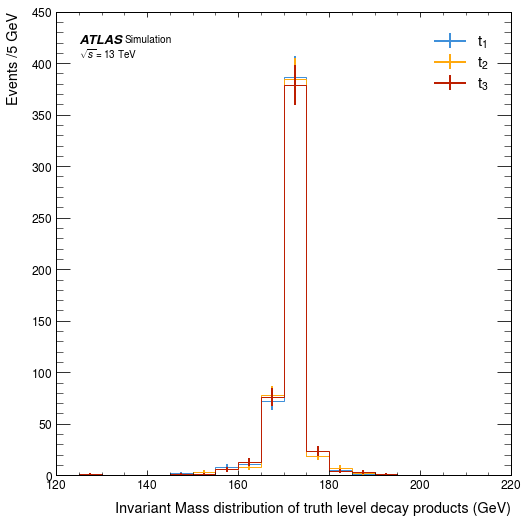

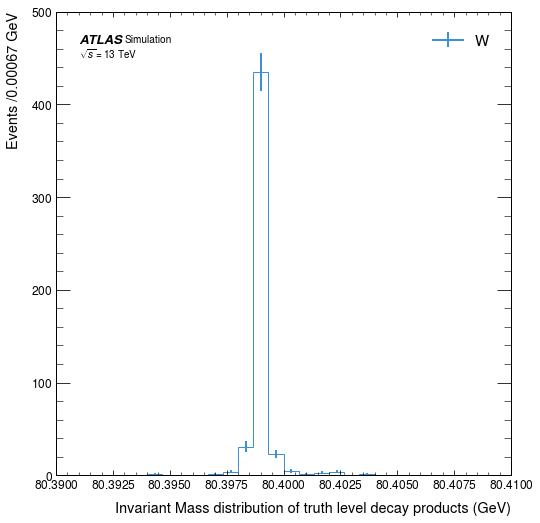

In [498]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
histogram([t1.m, t2.m, t3.m], 20, [r't$_1$', r't$_2$', r't$_3$'], ax, density = False, x_units='GeV', set_range=(120,220))
ax.set_xlabel(r'Invariant Mass distribution of truth level decay products (GeV)')
ax.legend(fontsize=15)
plt.subplots_adjust(hspace=0.25)

plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
histogram([W.m], 30,[r'W'], ax, density = False, x_units='GeV', set_range=(80.39,80.41))
ax.set_xlabel(r'Invariant Mass distribution of truth level decay products (GeV)')
ax.legend(fontsize=15)
plt.subplots_adjust(hspace=0.25)

plt.show()

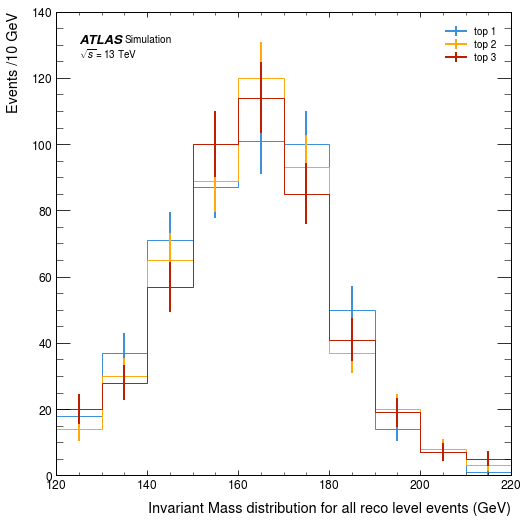

In [501]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
histogram([top_1_3tW.m, top_2_3tW.m, top_3_3tW.m], 10, ['top 1', 'top 2', 'top 3'], ax, density = False, x_units='GeV', set_range=(120,220))
ax.set_xlabel(r'Invariant Mass distribution for all reco level events (GeV)')
plt.subplots_adjust(hspace=0.25)
plt.show()

Peak bin center for Reco Tops: 162.50 GeV
Peak bin center for Truth Tops: 172.50 GeV


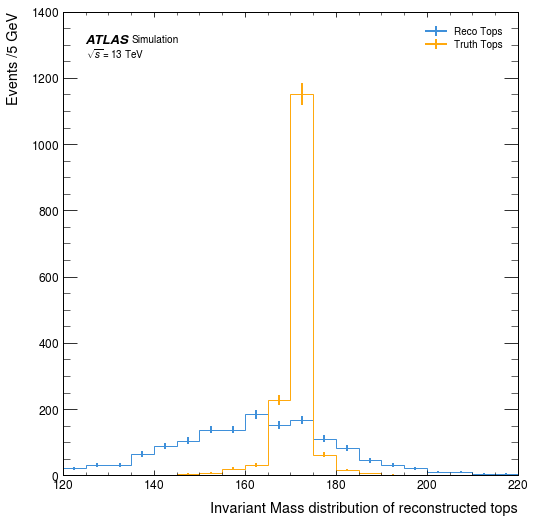

In [502]:
reco_tops_3tW = ak.concatenate((top_1_3tW, top_2_3tW, top_3_3tW))
truth_tops_3tW = ak.concatenate((t1, t2, t3))

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
histogram([reco_tops_3tW.m,truth_tops_3tW.m], 20, ['Reco Tops', 'Truth Tops'], ax, density = False, x_units='GeV', print_peak=True, set_range=(120,220))
ax.set_xlabel(r'Invariant Mass distribution of reconstructed tops')
plt.subplots_adjust(hspace=0.25)
plt.show()

In [504]:
tops_pt_4t = np.transpose(np.vstack(((top_1_4t_0L.pt,top_2_4t_0L.pt,antitop_1_4t_0L.pt,antitop_2_4t_0L.pt))))
tops_eta_4t = np.transpose(np.vstack(((top_1_4t_0L.eta,top_2_4t_0L.eta,antitop_1_4t_0L.eta,antitop_2_4t_0L.eta))))
tops_phi_4t = np.transpose(np.vstack(((top_1_4t_0L.phi,top_2_4t_0L.phi,antitop_1_4t_0L.phi,antitop_2_4t_0L.phi))))
tops_mass_4t = np.transpose(np.vstack(((top_1_4t_0L.m,top_2_4t_0L.m,antitop_1_4t_0L.m,antitop_2_4t_0L.m))))

top_1_3t = ak.concatenate((top_1_3tj,top_1_3tW))
top_2_3t = ak.concatenate((top_2_3tj,top_2_3tW))
top_3_3t = np.concatenate((top_3_3tj,top_3_3tW))

tops_pt_3t = np.transpose(np.vstack(((top_1_3t.pt,top_2_3t.pt,top_3_3t.pt))))
tops_eta_3t = np.transpose(np.vstack(((top_1_3t.eta,top_2_3t.eta,top_3_3t.eta))))
tops_phi_3t = np.transpose(np.vstack(((top_1_3t.phi,top_2_3t.phi,top_3_3t.phi))))
tops_mass_3t = np.transpose(np.vstack(((top_1_3t.m,top_2_3t.m,top_3_3t.m))))


tops_4t = vector.zip({'pt':tops_pt_4t,'eta':tops_eta_4t,'phi':tops_phi_4t, 'mass':tops_mass_4t})
tops_3t = vector.zip({'pt':tops_pt_3t,'eta':tops_eta_3t,'phi':tops_phi_3t, 'mass':tops_mass_3t})

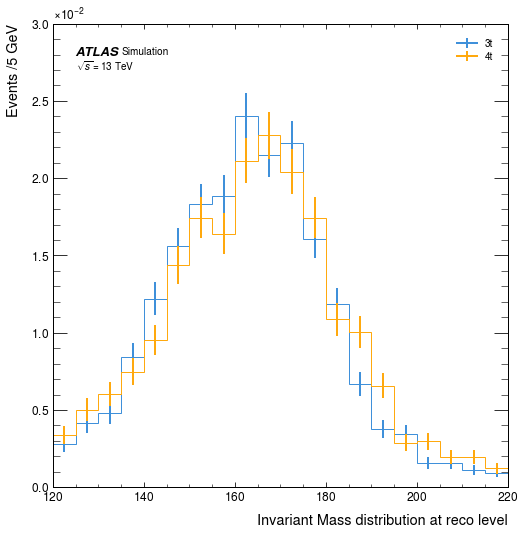

In [506]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
histogram([ak.flatten(tops_3t).m, ak.flatten(tops_4t).m], 20, ['3t', '4t'], ax, density = True, x_units='GeV', set_range=(120,220))
ax.set_xlabel(r'Invariant Mass distribution at reco level')
plt.subplots_adjust(hspace=0.25)
plt.show()

In [312]:
duos_4t = ak.combinations(tops_4t, 2, axis=1)
duos_3t = ak.combinations(tops_3t, 2, axis=1)

duo_masses_4t = np.mean((duos_4t["0"]+duos_4t["1"]).m, axis=1)
deltaphi_4t = np.mean(duos_4t["0"].deltaphi(duos_4t["1"]), axis=1)
deltaR_4t = np.mean(duos_4t["0"].deltaR(duos_4t["1"]), axis=1)
deltaeta_4t = np.mean(np.abs(duos_4t["0"].deltaeta(duos_4t["1"])), axis=1)
deltapt_4t = np.abs(np.mean((duos_4t["0"].pt - (duos_4t["1"]).pt), axis=1))

duo_masses_3t = np.mean((duos_3t["0"]+duos_3t["1"]).m, axis=1)
deltaphi_3t = np.mean(duos_3t["0"].deltaphi(duos_3t["1"]), axis=1)
deltaR_3t = np.mean(duos_3t["0"].deltaR(duos_3t["1"]), axis=1)
deltaeta_3t = np.mean(np.abs(duos_3t["0"].deltaeta(duos_3t["1"])), axis=1)
deltapt_3t = np.abs(np.mean((duos_3t["0"].pt - (duos_3t["1"]).pt), axis=1))

## Sorting

In [276]:
#pt
sorted_indices = np.argsort(tops_4t.rho)
trans_sorted_4t = tops_4t[sorted_indices]

highest_pt_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
second_highest_pt_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
third_highest_pt_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
lowest_pt_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(tops_3t.rho)
trans_sorted_3t = tops_3t[sorted_indices]

highest_pt_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
middle_pt_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
lowest_pt_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

#eta
sorted_indices = np.argsort(tops_4t.eta)
trans_sorted_4t = tops_4t[sorted_indices]

highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
second_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
third_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
lowest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(tops_3t.eta)
trans_sorted_3t = tops_3t[sorted_indices]

highest_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
middle_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
lowest_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.abs(tops_4t.eta))
trans_sorted_4t = tops_4t[sorted_indices]

abs_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
abs_second_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
abs_third_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
abs_lowest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.abs(tops_3t.eta))
trans_sorted_3t = tops_3t[sorted_indices]

abs_highest_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
abs_middle_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
abs_lowest_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

#phi
sorted_indices = np.argsort(tops_4t.phi)
trans_sorted_4t = tops_4t[sorted_indices]

highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
second_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
third_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
lowest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(tops_3t.phi)
trans_sorted_3t = tops_3t[sorted_indices]

highest_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
middle_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
lowest_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.abs(tops_4t.phi))
trans_sorted_4t = tops_4t[sorted_indices]

abs_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
abs_second_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
abs_third_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
abs_lowest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.abs(tops_3t.phi))
trans_sorted_3t = tops_3t[sorted_indices]

abs_highest_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
abs_middle_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
abs_lowest_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

#Energy
sorted_indices = np.argsort(np.sqrt((tops_4t.rho**2)*(np.cosh(tops_4t.eta)**2) + tops_4t.tau**2))
trans_sorted_4t = tops_4t[sorted_indices]

highest_e_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
second_highest_e_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
third_highest_e_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
lowest_e_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.sqrt((tops_3t.rho**2)*(np.cosh(tops_3t.eta)**2) + tops_3t.tau**2))
trans_sorted_3t = tops_3t[sorted_indices]

highest_e_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
middle_e_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
lowest_e_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

## Calculations

In [277]:
#deltaR
pt_deltaR_4t = highest_pt_4t.deltaR(second_highest_pt_4t)
eta_deltaR_4t = highest_eta_4t.deltaR(second_highest_eta_4t)
abs_eta_deltaR_4t = abs_highest_eta_4t.deltaR(abs_second_highest_eta_4t)
phi_deltaR_4t = lowest_phi_4t.deltaR(third_highest_phi_4t)
abs_phi_deltaR_4t = abs_highest_phi_4t.deltaR(abs_second_highest_phi_4t)
e_deltaR_4t = highest_e_4t.deltaR(second_highest_e_4t)

pt_deltaR_3t = highest_pt_3t.deltaR(middle_pt_3t)
eta_deltaR_3t = highest_eta_3t.deltaR(middle_eta_3t)
abs_eta_deltaR_3t = abs_highest_eta_3t.deltaR(abs_middle_eta_3t)
phi_deltaR_3t = lowest_phi_3t.deltaR(middle_phi_3t)
abs_phi_deltaR_3t = abs_highest_phi_3t.deltaR(abs_middle_phi_3t)
e_deltaR_3t = highest_e_3t.deltaR(middle_e_3t)

#deltaphi
high_delta_phi_4t = np.abs(highest_phi_4t.deltaphi(second_highest_phi_4t))
high_delta_eta_4t = np.abs(highest_phi_4t.deltaeta(second_highest_phi_4t))
low_delta_phi_4t = np.abs(third_highest_phi_4t.deltaphi(lowest_phi_4t))
low_delta_eta_4t = np.abs(third_highest_phi_4t.deltaeta(lowest_phi_4t))

high_delta_phi_3t = np.abs(highest_phi_3t.deltaphi(middle_phi_3t))
high_delta_eta_3t = np.abs(highest_phi_3t.deltaeta(middle_phi_3t))
low_delta_phi_3t = np.abs(middle_phi_3t.deltaphi(lowest_phi_3t))
low_delta_eta_3t = np.abs(middle_phi_3t.deltaeta(lowest_phi_3t))

#centrality
def centrality(particle, reference_1, reference_2):
    return np.abs(particle.rapidity - 0.5*(reference_1.rapidity + reference_2.rapidity))/np.abs(reference_1.rapidity-reference_2.rapidity)

centrality_1_3t = centrality(highest_pt_3t, middle_pt_3t, lowest_pt_3t)
centrality_2_3t = centrality(middle_pt_3t, highest_pt_3t, lowest_pt_3t)
centrality_3_3t = centrality(lowest_pt_3t, highest_pt_3t, middle_pt_3t)

centrality_1_4t = centrality(highest_pt_4t, second_highest_pt_4t, third_highest_pt_4t)
centrality_2_4t = centrality(second_highest_pt_4t, highest_pt_4t, third_highest_pt_4t)
centrality_3_4t = centrality(third_highest_pt_4t, highest_pt_4t, second_highest_pt_4t)

#Transverse Sphericity
sum_pt_3t = np.sum(tops_3t.pt, axis=1)
S_xy_3t = np.zeros((len(tops_3t),2,2))

S_xy_3t[:,0,0] = np.sum(tops_3t.px**2/ tops_3t.pt, axis=1)
S_xy_3t[:,0,1] = np.sum((tops_3t.px*tops_3t.py)/ tops_3t.pt, axis=1)
S_xy_3t[:,1,0] = S_xy_3t[:,0,1]
S_xy_3t[:,1,1] = np.sum(tops_3t.py**2/ tops_3t.pt, axis=1)

S_xy_3t = S_xy_3t/sum_pt_3t[:,np.newaxis,np.newaxis]

transverse_eigenvalues_3t = np.linalg.eigvalsh(S_xy_3t)
transverse_sphericity_3t = 2*np.min(transverse_eigenvalues_3t, axis=1)/np.sum(transverse_eigenvalues_3t, axis=1)

sum_pt_4t = np.sum(tops_4t.pt, axis=1)
S_xy_4t = np.zeros((len(tops_4t),2,2))

S_xy_4t[:,0,0] = np.sum(tops_4t.px**2/ tops_4t.pt, axis=1)
S_xy_4t[:,0,1] = np.sum((tops_4t.px*tops_4t.py)/ tops_4t.pt, axis=1)
S_xy_4t[:,1,0] = S_xy_4t[:,0,1]
S_xy_4t[:,1,1] = np.sum(tops_4t.py**2/ tops_4t.pt, axis=1)

S_xy_4t = S_xy_4t/sum_pt_4t[:,np.newaxis,np.newaxis]

transverse_eigenvalues_4t = np.linalg.eigvalsh(S_xy_4t)
transverse_sphericity_4t = 2*np.min(transverse_eigenvalues_4t, axis=1)/np.sum(transverse_eigenvalues_4t, axis=1)

#Spericity
sum_p_3t = np.sum(tops_3t.p, axis=1)
S_xyz_3t = np.zeros((len(tops_3t),3,3))

S_xyz_3t[:,0,0] = np.sum(tops_3t.px**2/ tops_3t.p, axis=1)
S_xyz_3t[:,0,1] = np.sum((tops_3t.px*tops_3t.py)/ tops_3t.p, axis=1)
S_xyz_3t[:,0,2] = np.sum((tops_3t.px*tops_3t.pz)/ tops_3t.p, axis=1)
S_xyz_3t[:,1,2] = np.sum((tops_3t.py*tops_3t.pz)/ tops_3t.p, axis=1)
S_xyz_3t[:,1,0] = S_xyz_3t[:,0,1]
S_xyz_3t[:,2,0] = S_xyz_3t[:,0,2]
S_xyz_3t[:,2,1] = S_xyz_3t[:,1,2]
S_xyz_3t[:,1,1] = np.sum(tops_3t.py**2/ tops_3t.p, axis=1)
S_xyz_3t[:,2,2] = np.sum(tops_3t.pz**2/ tops_3t.p, axis=1)

S_xyz_3t = S_xyz_3t/sum_p_3t[:,np.newaxis,np.newaxis]

eigenvalues_3t = np.linalg.eigvalsh(S_xyz_3t)
sphericity_3t = 2*np.min(eigenvalues_3t, axis=1)/np.sum(eigenvalues_3t, axis=1)

sum_p_4t = np.sum(tops_4t.p, axis=1)
S_xyz_4t = np.zeros((len(tops_4t),3,3))

S_xyz_4t[:,0,0] = np.sum(tops_4t.px**2/ tops_4t.p, axis=1)
S_xyz_4t[:,0,1] = np.sum((tops_4t.px*tops_4t.py)/ tops_4t.p, axis=1)
S_xyz_4t[:,0,2] = np.sum((tops_4t.px*tops_4t.pz)/ tops_4t.p, axis=1)
S_xyz_4t[:,1,2] = np.sum((tops_4t.py*tops_4t.pz)/ tops_4t.p, axis=1)
S_xyz_4t[:,1,0] = S_xyz_4t[:,0,1]
S_xyz_4t[:,2,0] = S_xyz_4t[:,0,2]
S_xyz_4t[:,2,1] = S_xyz_4t[:,1,2]
S_xyz_4t[:,1,1] = np.sum(tops_4t.py**2/ tops_4t.p, axis=1)
S_xyz_4t[:,2,2] = np.sum(tops_4t.pz**2/ tops_4t.p, axis=1)

S_xyz_4t = S_xyz_4t/sum_p_4t[:,np.newaxis,np.newaxis]

eigenvalues_4t = np.linalg.eigvalsh(S_xyz_4t)
sphericity_4t = 2*np.min(eigenvalues_4t, axis=1)/np.sum(eigenvalues_4t, axis=1)

#Total invariant mass
total_4_4t = np.sum(tops_4t, axis=1)
total_4_3t = np.sum(tops_3t, axis=1)

/Users/archiebrooks/opt/anaconda3/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:249: RuntimeWarning: divide by zero encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


In [278]:
print(np.shape(tops_4t))

[6034, 4]


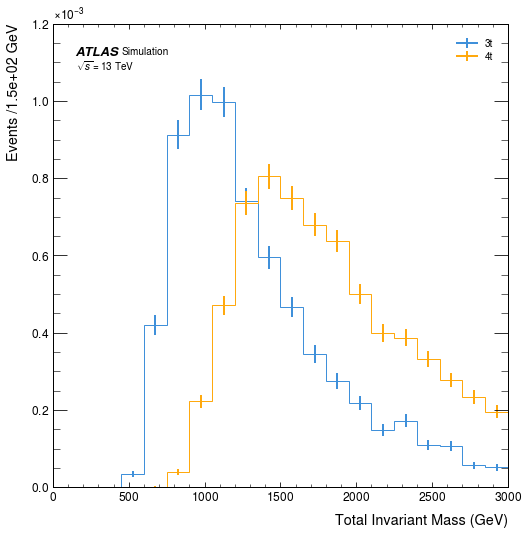

In [279]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
histogram([total_4_3t.m, total_4_4t.m], 20, ['3t', '4t'], ax, density = True, x_units='GeV', set_range=(0,3000))
ax.set_xlabel(r'Total Invariant Mass (GeV)')
plt.subplots_adjust(hspace=0.25)
plt.show()

## Plots

### Basic Kinematics

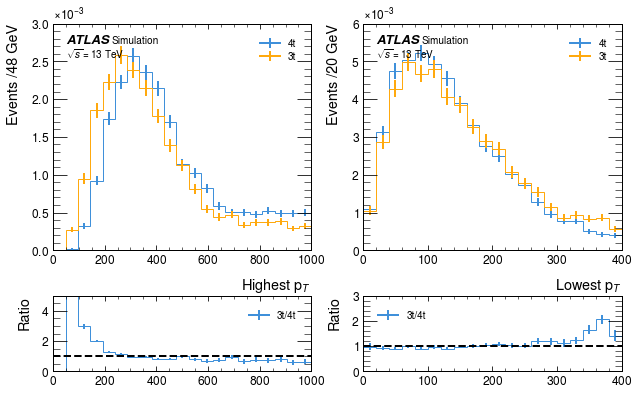

In [308]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,6))
histogram([highest_pt_4t.pt, highest_pt_3t.pt], 20, [r'4t', '3t'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(50,1000))
histogram([lowest_pt_4t.pt, lowest_pt_3t.pt], 20, ['4t', '3t'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(0,400))
ax[0,0].set_xlabel(r'Highest p$_T$')
ax[0,1].set_xlabel(r'Lowest p$_T$')
plt.subplots_adjust(hspace=0.3)
plt.show()

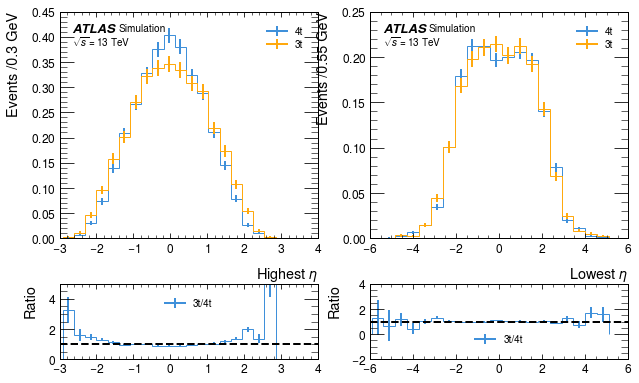

In [284]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,6))
histogram([highest_pt_4t.eta, highest_pt_3t.eta], 20, [r'4t', '3t'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0])
histogram([lowest_pt_4t.eta, lowest_pt_3t.eta], 20, ['4t', '3t'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1])
ax[0,0].set_xlabel(r'Highest $\eta$')
ax[0,1].set_xlabel(r'Lowest $\eta$')
plt.subplots_adjust(hspace=0.3)
plt.show()

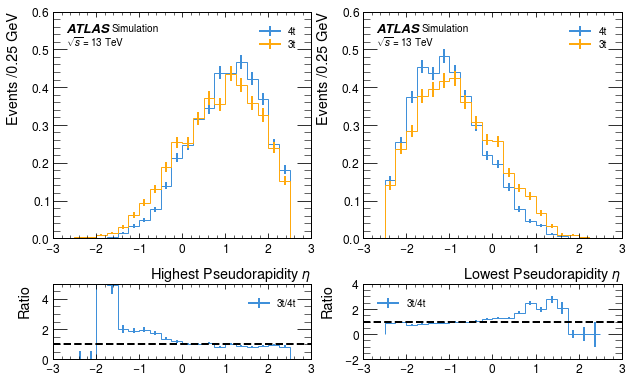

In [286]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,6))
histogram([highest_eta_4t.eta, highest_eta_3t.eta], 20, [r'4t', r'3t'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(-2.5,2.5))
ax[0,0].set_xlabel(r'Highest Pseudorapidity $\eta$')
histogram([lowest_eta_4t.eta, lowest_eta_3t.eta], 20, [r'4t', r'3t'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(-2.5,2.5))
ax[0,1].set_xlabel(r'Lowest Pseudorapidity $\eta$')
plt.subplots_adjust(hspace=0.3)
plt.show()

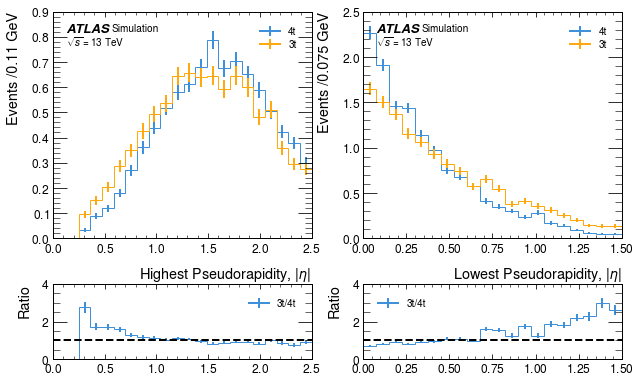

In [288]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,6))
histogram([np.abs(abs_highest_eta_4t.eta), np.abs(abs_highest_eta_3t.eta)], 20, [r'4t', r'3t'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(0.25,2.5))
ax[0,0].set_xlabel(r'Highest Pseudorapidity, $|\eta|$')
histogram([np.abs(abs_lowest_eta_4t.eta), np.abs(abs_lowest_eta_3t.eta)], 20, [r'4t', r'3t'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(0,1.5))
ax[0,1].set_xlabel(r'Lowest Pseudorapidity, $|\eta|$')
plt.subplots_adjust(hspace=0.3)
plt.show()

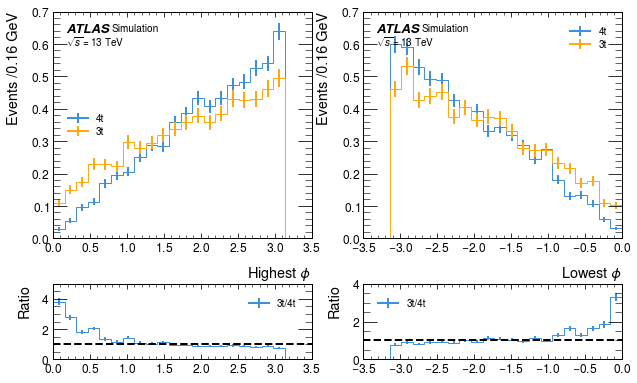

In [289]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,6))
histogram([highest_phi_4t.phi, highest_phi_3t.phi], 20, ['4t', '3t'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(0,np.pi))
ax[0,0].set_xlabel(r'Highest $\phi$')
histogram([lowest_phi_4t.phi, lowest_phi_3t.phi], 20, ['4t', '3t'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(-np.pi,0))
ax[0,1].set_xlabel(r'Lowest $\phi$')
plt.subplots_adjust(hspace=0.3)
plt.show()

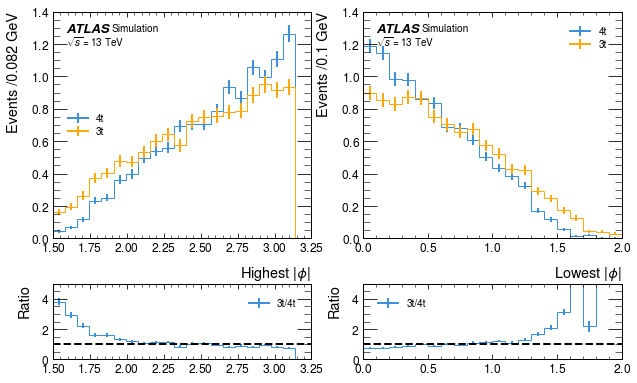

In [290]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,6))
histogram([np.abs(abs_highest_phi_4t.phi), np.abs(abs_highest_phi_3t.phi)], 20, ['4t', '3t'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(1.5,np.pi))
ax[0,0].set_xlabel(r'Highest $|\phi|$')
histogram([np.abs(abs_lowest_phi_4t.phi), np.abs(abs_lowest_phi_3t.phi)], 20, ['4t', '3t'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(0,2))
ax[0,1].set_xlabel(r'Lowest $|\phi|$')
plt.subplots_adjust(hspace=0.3)
plt.show()

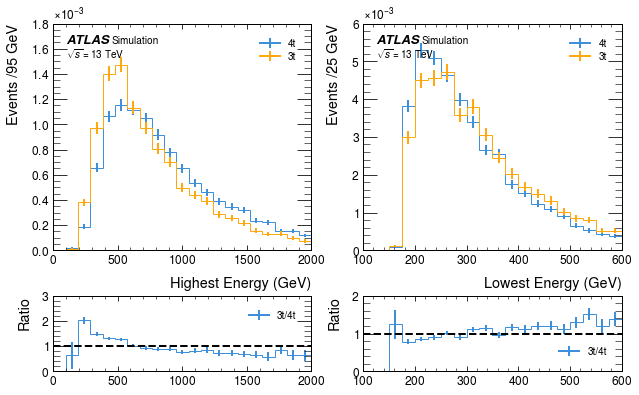

In [291]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,6))
histogram([highest_e_4t.E, highest_e_3t.E], 20, ['4t', '3t'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(100,2000))
ax[0,0].set_xlabel(r'Highest Energy (GeV)')
histogram([lowest_e_4t.E, lowest_e_3t.E], 20, ['4t', '3t'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(100,600))
ax[0,1].set_xlabel(r'Lowest Energy (GeV)')
plt.subplots_adjust(hspace=0.3)
plt.show()

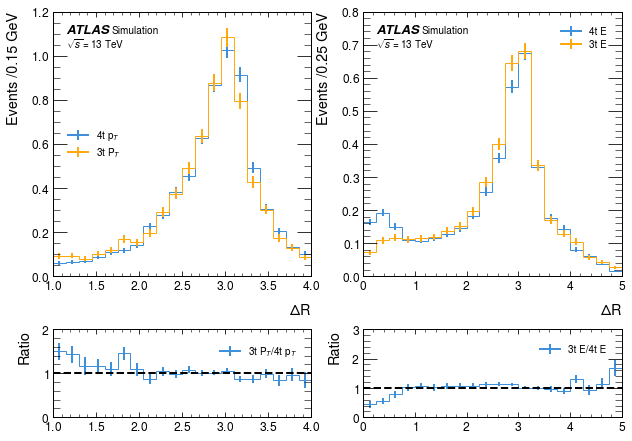

In [292]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,7))
plt.subplots_adjust(hspace=0.3)
histogram([pt_deltaR_4t, pt_deltaR_3t], 20, [r'4t p$_T$', r'3t P$_T$'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(1,4))
ax[0,0].set_xlabel(r'$\Delta$R')
histogram([e_deltaR_4t, e_deltaR_3t], 20, [r'4t E', r'3t E'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(0,5))
ax[0,1].set_xlabel(r'$\Delta$R')
plt.show()

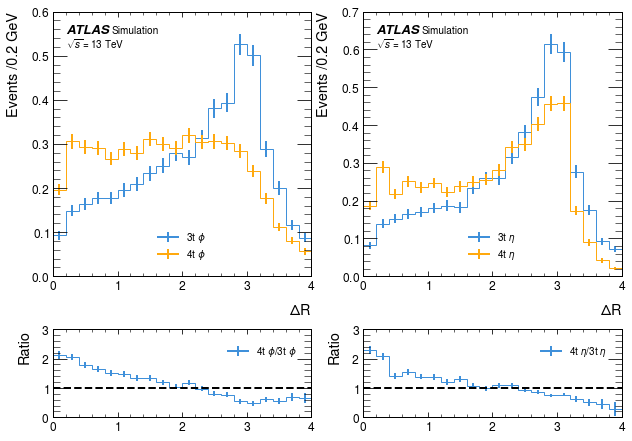

In [293]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,7))
plt.subplots_adjust(hspace=0.3)
histogram([phi_deltaR_3t, phi_deltaR_4t], 20, [r'3t $\phi$', r'4t $\phi$'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(0,4))
ax[0,0].set_xlabel(r'$\Delta$R')
histogram([eta_deltaR_3t, eta_deltaR_4t], 20, [r'3t $\eta$', r'4t $\eta$'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(0,4))
ax[0,1].set_xlabel(r'$\Delta$R')
plt.show()

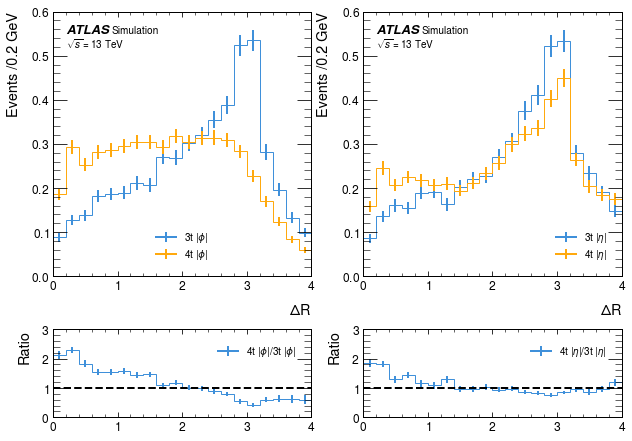

In [294]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,7))
plt.subplots_adjust(hspace=0.3)
histogram([abs_phi_deltaR_3t, abs_phi_deltaR_4t], 20, [r'3t $|\phi|$', r'4t $|\phi|$'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(0,4))
ax[0,0].set_xlabel(r'$\Delta$R')
histogram([abs_eta_deltaR_3t, abs_eta_deltaR_4t], 20, [r'3t $|\eta|$', r'4t $|\eta|$'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(0,4))
ax[0,1].set_xlabel(r'$\Delta$R')
plt.show()

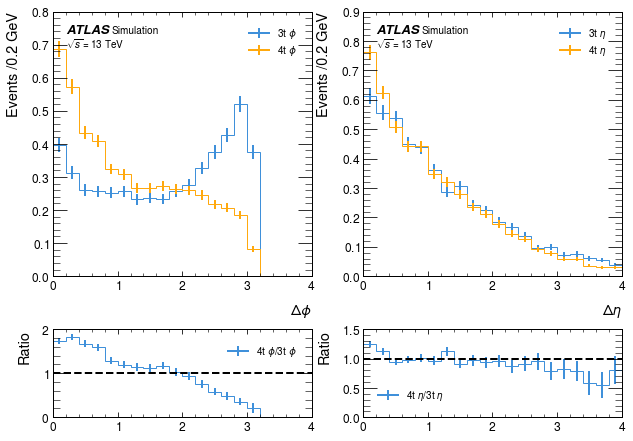

In [295]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,7))
plt.subplots_adjust(hspace=0.3)
histogram([high_delta_phi_3t, high_delta_phi_4t], 20, [r'3t $\phi$', r'4t $\phi$'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(0,4))
ax[0,0].set_xlabel(r'$\Delta\phi$')
histogram([high_delta_eta_3t, high_delta_eta_4t], 20, [r'3t $\eta$', r'4t $\eta$'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(0,4))
ax[0,1].set_xlabel(r'$\Delta\eta$')
plt.show()

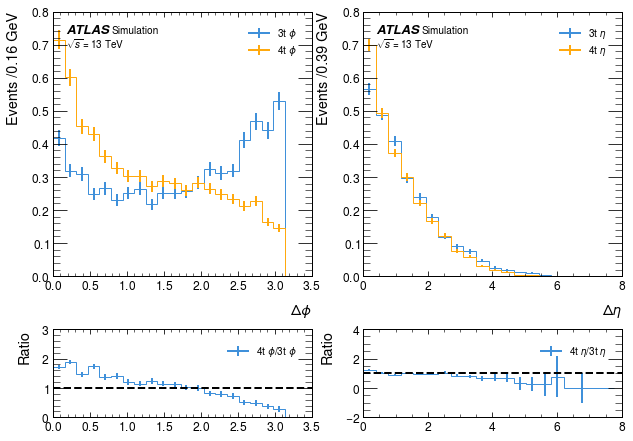

In [296]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,7))
plt.subplots_adjust(hspace=0.3)
histogram([low_delta_phi_3t, low_delta_phi_4t], 20, [r'3t $\phi$', r'4t $\phi$'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0])
ax[0,0].set_xlabel(r'$\Delta\phi$')
histogram([low_delta_eta_3t, low_delta_eta_4t], 20, [r'3t $\eta$', r'4t $\eta$'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1])
ax[0,1].set_xlabel(r'$\Delta\eta$')
plt.show()

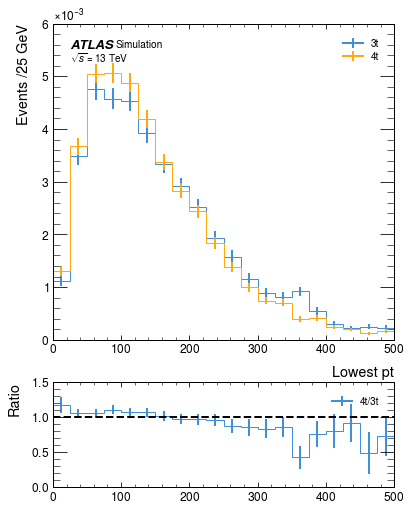

In [298]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([lowest_pt_3t.rho, lowest_pt_4t.rho], 20, ['3t', '4t'], ax[0],density=True, ratio=True, ratio_axes=ax[1], set_range=(0,500))
ax[0].set_xlabel('Lowest pt')
plt.show()

### High Level Partonic Analysis

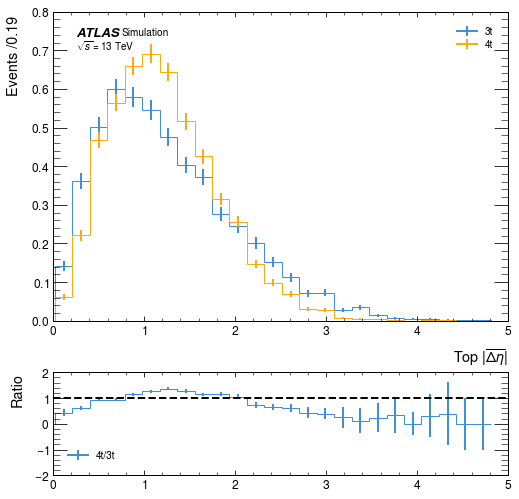

In [299]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]}, figsize=(8,8))
histogram([deltaeta_3t,deltaeta_4t], 25, ['3t','4t'], ax[0], ratio=True, ratio_axes=ax[1], density=True, x_units='')
ax[0].set_xlabel(r'Top $|\overline{\Delta\eta}|$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

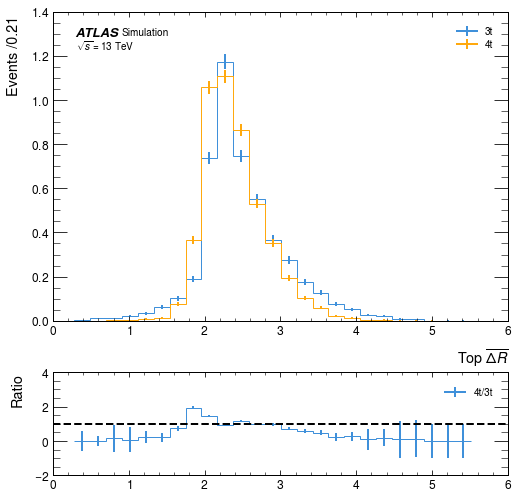

In [302]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]}, figsize=(8,8))
histogram([deltaR_3t,deltaR_4t], 25, ['3t','4t'], ax[0], ratio=True, ratio_axes=ax[1], density=True, x_units='')
ax[0].set_xlabel(r'Top $\overline{\Delta R}$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

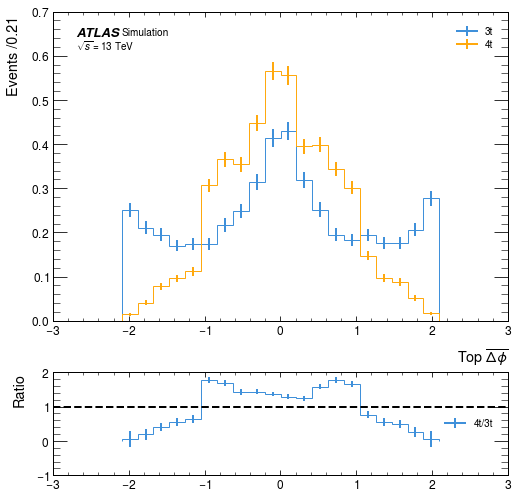

In [303]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]}, figsize=(8,8))
histogram([deltaphi_3t,deltaphi_4t], 20, ['3t','4t'], ax[0], ratio=True, ratio_axes=ax[1], density=True, x_units='')
ax[0].set_xlabel(r'Top $\overline{\Delta \phi}$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

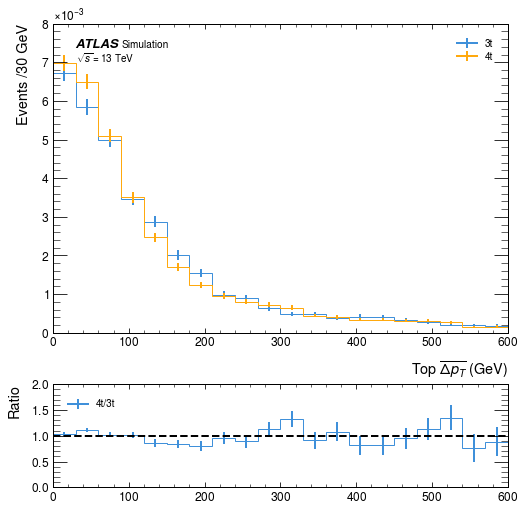

In [315]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]}, figsize=(8,8))
histogram([deltapt_3t,deltapt_4t], 20, ['3t','4t'], ax[0], ratio=True, ratio_axes=ax[1], density=True, x_units='GeV', set_range=(0,600))
ax[0].set_xlabel(r'Top $\overline{\Delta p_T}$ (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

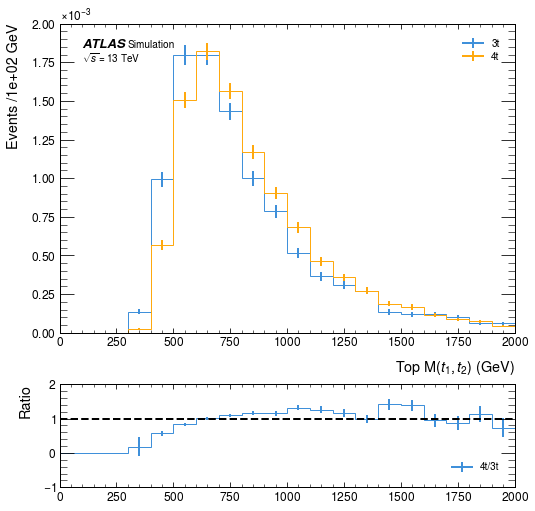

In [317]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]}, figsize=(8,8))
histogram([duo_masses_3t,duo_masses_4t], 20, ['3t','4t'], ax[0], ratio=True, ratio_axes=ax[1], density=True, x_units='GeV', set_range=(0,2000))
ax[0].set_xlabel(r'Top M($t_1,t_2$) (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

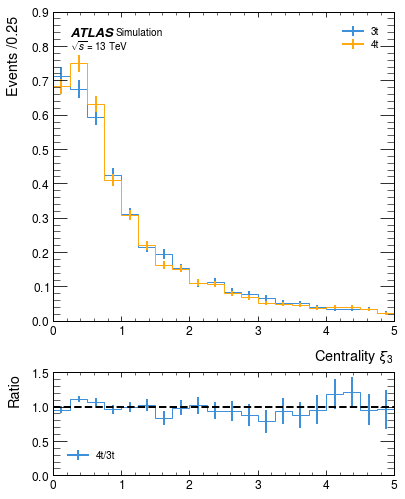

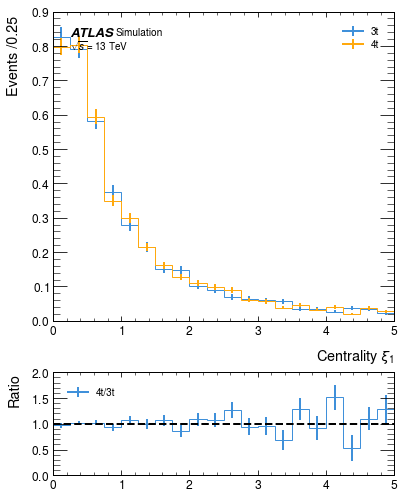

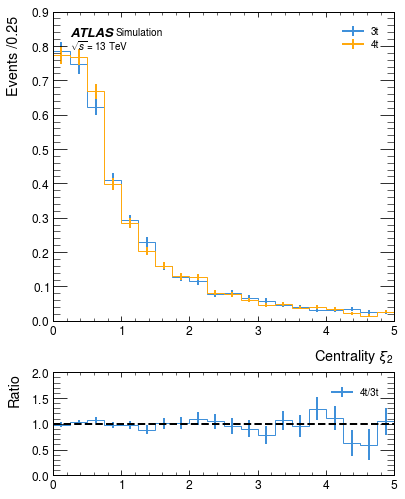

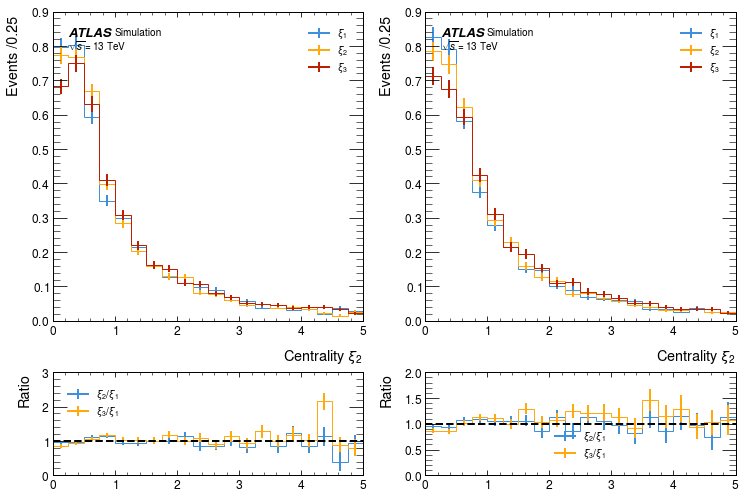

In [319]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3,1]},figsize = (6,8))
histogram([centrality_3_3t, centrality_3_4t], 20, ['3t', '4t'], ax[0], density = True, set_range=(0,5), ratio=True, ratio_axes=ax[1], x_units='')
ax[0].set_xlabel(r'Centrality $\xi_3$')
fig.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([centrality_1_3t, centrality_1_4t], 20, ['3t', '4t'], ax[0], density = True, ratio=True, ratio_axes=ax[1], set_range=(0,5), x_units='')
ax[0].set_xlabel(r'Centrality $\xi_1$')
plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([centrality_2_3t, centrality_2_4t], 20, ['3t', '4t'], ax[0], density = True, ratio=True, ratio_axes=ax[1], set_range=(0,5), x_units='')
ax[0].set_xlabel(r'Centrality $\xi_2$')
plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (12,8))
histogram([centrality_1_4t, centrality_2_4t, centrality_3_4t], 20, [r'$\xi_1$', r'$\xi_2$', r'$\xi_3$'], ax[0,0], density = True, ratio=True, ratio_axes=ax[1,0], set_range=(0,5), x_units='')
ax[0,0].set_xlabel(r'Centrality $\xi_2$')
histogram([centrality_1_3t, centrality_2_3t, centrality_3_3t], 20, [r'$\xi_1$', r'$\xi_2$', r'$\xi_3$'], ax[0,1], density = True, ratio=True, ratio_axes=ax[1,1], set_range=(0,5), x_units='')
ax[0,1].set_xlabel(r'Centrality $\xi_2$')
plt.subplots_adjust(hspace=0.25)
plt.show()

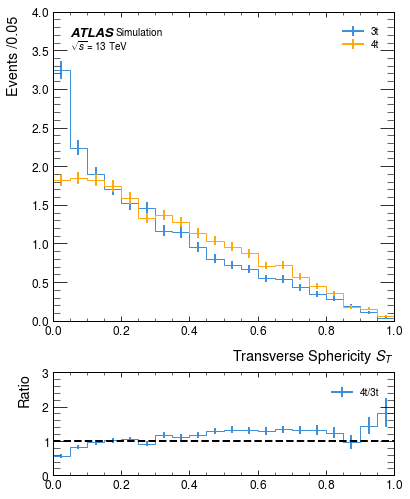

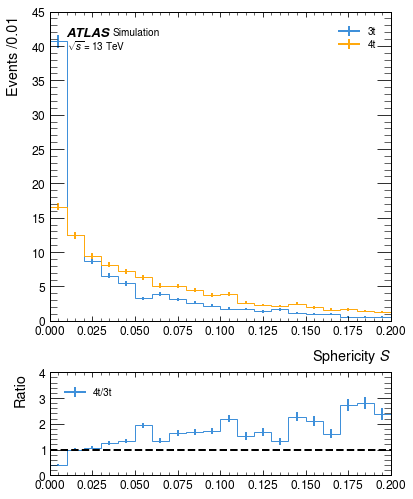

In [321]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([transverse_sphericity_3t, transverse_sphericity_4t], 20, ['3t', '4t'], ax[0], density = True, ratio=True, ratio_axes=ax[1], set_range=(0,1), x_units='')
ax[0].set_xlabel(r'Transverse Sphericity $S_T$')
plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([sphericity_3t, sphericity_4t], 20, ['3t', '4t'], ax[0], density = True, ratio=True, ratio_axes=ax[1], set_range=(0,0.2), x_units='')
ax[0].set_xlabel(r'Sphericity $S$')
plt.subplots_adjust(hspace=0.25)
plt.show()

# Possible Code for use later

In [ ]:
truth_level_numbers = list(dict.fromkeys(ak.num(truth_4t_test)))

truth_4t_dict = {}
reco_4t_dict = {}

for truth_number in truth_level_numbers:
    truth_4t_dict[f'truth_particles_{truth_number}'] = truth_4t_test[ak.num(truth_4t_test)==truth_number]
    reco_4t_dict[f'truth_particles_{truth_number}'] = reco_4t_test[ak.num(truth_4t_test)==truth_number]

for key in truth_4t_dict.keys():
    truth_particles = truth_4t_dict[key]
    reco_particles = reco_4t_dict[key]
    num = ak.num(truth_particles)[0]
    pairs = ak.cartesian({'truth':truth_particles,'reco':reco_particles})
    pairs = ak.unflatten(pairs, num, axis=1)
    deltars = pairs['reco'].deltaR(pairs['truth'])
    print(np.shape(pairs['truth'][1]))
    pairs = pairs[deltars == np.min(deltars, axis=1)]
    deltars = np.min(deltars, axis=1)
    pairs = pairs[deltars<0.4]
    print('Next Key')